In [1]:
import sys
sys.path.append('../')
from simCRN.multivariate_reg import read_eq_data_file
from simCRN.multivariate_reg import convert_np2df
from simCRN.multivariate_reg import get_stats
from simCRN.multivariate_reg import Z_normalize_data
from simCRN.multivariate_reg import min_max_normalize
from simCRN.multivariate_reg import prep_data
from simCRN.multivariate_reg import plot_data
from simCRN.multivariate_reg import plot_predict
from simCRN.multivariate_reg import plot_true_and_pred
from simCRN.multivariate_reg import plot_error_hist
from simCRN.multivariate_reg import plot_true_v_error
from simCRN.multivariate_reg import plot_residuals
from simCRN.multivariate_reg import subset
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
import matplotlib.pyplot as plt
from tensorflow.keras.layers import LeakyReLU
import math
import numpy as np

ModuleNotFoundError: No module named 'simCRN'

In [2]:
# Read in data
Ci_all_array, Am_array, Cmin, Cmax, Ai = \
read_eq_data_file('4-4-2-asym-AB-AC.txt')

In [3]:
# Prep data
Am_df, Ci_df, train_Am_df, train_Ci_df, test_Am_df, test_Ci_df = \
prep_data(Am_array, Ci_all_array, 0.8)

In [4]:
# Normalize data
train_Am_stats = get_stats(train_Am_df)
normed_train_Am_df = Z_normalize_data(train_Am_df, train_Am_stats)
normed_test_Am_df = Z_normalize_data(test_Am_df, train_Am_stats)
train_Ci_stats = get_stats(train_Ci_df)
normed_train_Ci_df = Z_normalize_data(train_Ci_df, train_Ci_stats)
normed_test_Ci_df = Z_normalize_data(test_Ci_df, train_Ci_stats)

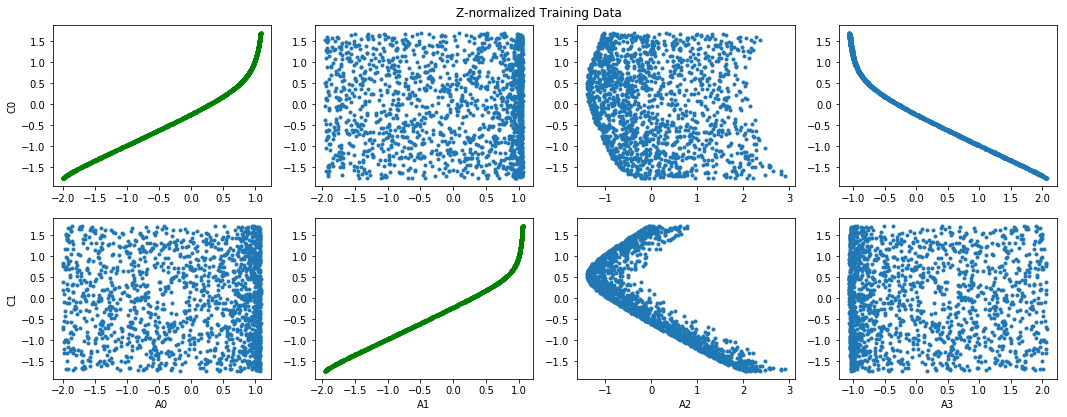

In [5]:
plot_data(normed_train_Am_df, normed_train_Ci_df, \
          title='Z-normalized Training Data')

(9e-08, 9.05e-08)

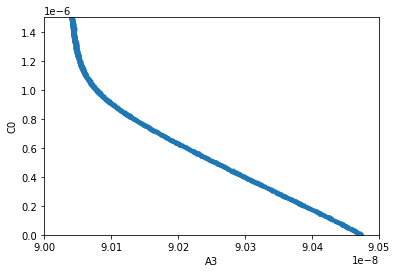

In [6]:
plt.scatter(train_Am_df['A3'],train_Ci_df['C0'], marker='.')
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.xlabel('A3')
plt.ylabel('C0')
plt.ylim(0,1.5e-6)
plt.xlim(9e-8,9.05e-8)
# plt.xlim(0,1e-6)

(7.3e-08, 7.32e-08)

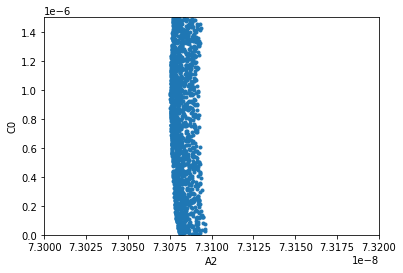

In [7]:
plt.scatter(train_Am_df['A2'],train_Ci_df['C0'], marker='.')
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.xlabel('A2')
plt.ylabel('C0')
plt.ylim(0,1.5e-6)
plt.xlim(7.3e-8,7.32e-8)
# plt.xlim(0,1e-6)

(7.3e-08, 7.32e-08)

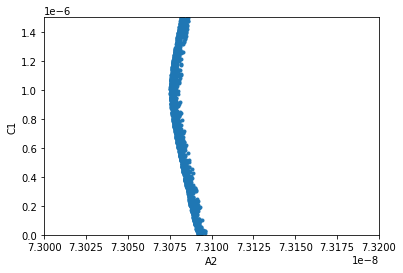

In [8]:
plt.scatter(train_Am_df['A2'],train_Ci_df['C1'], marker='.')
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.xlabel('A2')
plt.ylabel('C1')
plt.ylim(0,1.5e-6)
plt.xlim(7.3e-8,7.32e-8)
# plt.xlim(0,1e-7)

In [9]:
EPOCHS = 1000
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

In [10]:
def build_model(num_nodes, num_layers, act_func):
    model = keras.Sequential()
    model.add(layers.Dense(num_nodes, activation=act_func, input_shape=[len(train_Am_df.keys())]))
    for i in range(num_layers - 1):
        model.add(layers.Dense(num_nodes, activation=act_func))
    model.add(layers.Dense(len(train_Ci_df.keys())))
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mse'])
    return model

Let's test a 50 node, 1 layer model

In [11]:
model_50_1 = build_model(50,1, "relu")


Epoch: 0, loss:0.2830,  mae:0.4135,  mse:0.2830,  val_loss:0.1187,  val_mae:0.2626,  val_mse:0.1187,  
....................................................................................................
Epoch: 100, loss:0.0008,  mae:0.0185,  mse:0.0008,  val_loss:0.0006,  val_mae:0.0167,  val_mse:0.0006,  
....................................................................................................
Epoch: 200, loss:0.0004,  mae:0.0146,  mse:0.0004,  val_loss:0.0007,  val_mae:0.0207,  val_mse:0.0007,  
....................................................................................................
Epoch: 300, loss:0.0003,  mae:0.0128,  mse:0.0003,  val_loss:0.0002,  val_mae:0.0099,  val_mse:0.0002,  
....................................................................................................
Epoch: 400, loss:0.0003,  mae:0.0126,  mse:0.0003,  val_loss:0.0001,  val_mae:0.0083,  val_mse:0.0001,  
........................................................................

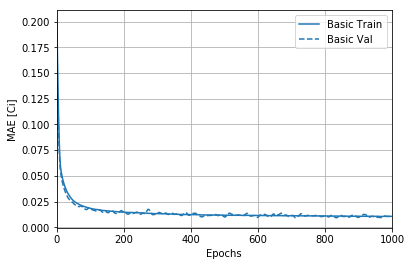

In [12]:
history_50_1 = model_50_1.fit(normed_train_Am_df, normed_train_Ci_df,
  epochs=EPOCHS, validation_split = 0.1, verbose=0,
  callbacks=[tfdocs.modeling.EpochDots()])
plotter.plot({'Basic': history_50_1}, metric = "mae")
plt.ylabel('MAE [Ci]')
plt.show()

In [13]:
loss_50_1, mae_50_1, mse_50_1 = \
model_50_1.evaluate(normed_test_Am_df, normed_test_Ci_df, verbose=2)

400/400 - 0s - loss: 1.0268e-04 - mae: 0.0070 - mse: 1.0268e-04


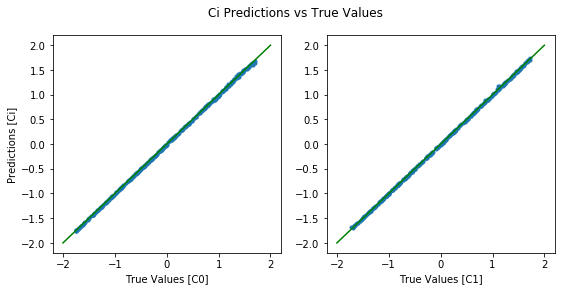

In [14]:
test_predictions_50_1 = model_50_1.predict(normed_test_Am_df)
plot_predict(test_predictions_50_1, normed_test_Ci_df, lims=[-2,2])

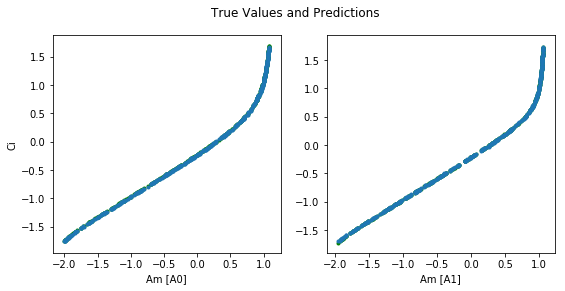

In [15]:
plot_true_and_pred(normed_test_Ci_df, test_predictions_50_1, normed_test_Am_df)

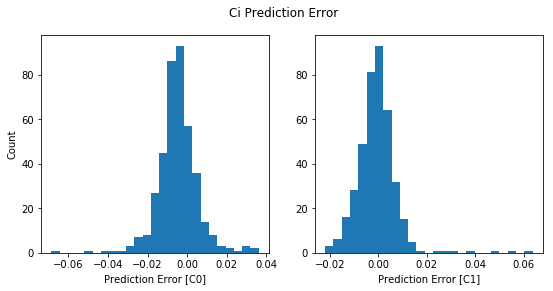

In [16]:
error_50_1 = test_predictions_50_1 - normed_test_Ci_df
plot_error_hist(error_50_1)

In [17]:
# Scaled MAE
scaled_mae_50_1 = error_50_1.abs().mean()*train_Ci_stats['std']
print(scaled_mae_50_1)

C0    3.624574e-09
C1    2.454532e-09
dtype: float64


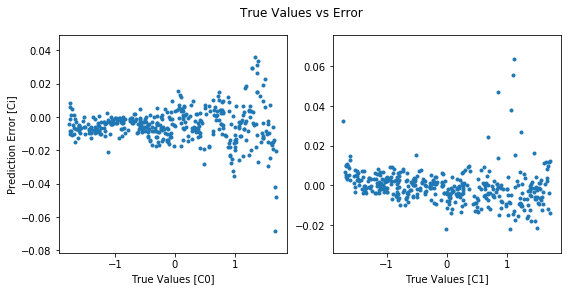

In [18]:
plot_true_v_error(normed_test_Ci_df, error_50_1)

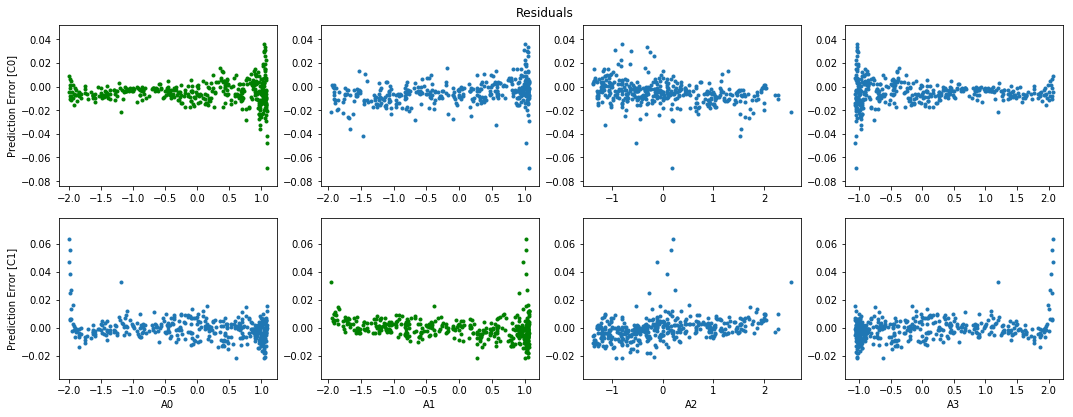

In [19]:
plot_residuals(normed_test_Am_df, error_50_1, green_list=[(0,0),(1,1),(2,2),(3,3)])

Now let's try using 1000 samples.

In [20]:
train_Am_df_50, train_Ci_df_50, test_Am_df_50, test_Ci_df_50, large_test_Am_df_50, \
        large_test_Ci_df_50 = subset(Am_df, Ci_df, 0.50, 0.8)

In [21]:
# Normalize data
train_Am_stats_50 = get_stats(train_Am_df_50)
normed_train_Am_df_50 = Z_normalize_data(train_Am_df_50, train_Am_stats_50)
normed_test_Am_df_50 = Z_normalize_data(test_Am_df_50, train_Am_stats_50)
large_normed_test_Am_df_50 = Z_normalize_data(large_test_Am_df_50, train_Am_stats_50)
train_Ci_stats_50 = get_stats(train_Ci_df_50)
normed_train_Ci_df_50 = Z_normalize_data(train_Ci_df_50, train_Ci_stats_50)
normed_test_Ci_df_50 = Z_normalize_data(test_Ci_df_50, train_Ci_stats_50)
large_normed_test_Ci_df_50 = Z_normalize_data(large_test_Ci_df_50, train_Ci_stats_50)

In [22]:
model_50_1_50 = build_model(50,1,"relu")


Epoch: 0, loss:0.8196,  mae:0.7414,  mse:0.8196,  val_loss:0.4849,  val_mae:0.5595,  val_mse:0.4849,  
....................................................................................................
Epoch: 100, loss:0.0018,  mae:0.0265,  mse:0.0018,  val_loss:0.0014,  val_mae:0.0218,  val_mse:0.0014,  
....................................................................................................
Epoch: 200, loss:0.0007,  mae:0.0172,  mse:0.0007,  val_loss:0.0007,  val_mae:0.0179,  val_mse:0.0007,  
....................................................................................................
Epoch: 300, loss:0.0005,  mae:0.0144,  mse:0.0005,  val_loss:0.0009,  val_mae:0.0207,  val_mse:0.0009,  
....................................................................................................
Epoch: 400, loss:0.0005,  mae:0.0145,  mse:0.0005,  val_loss:0.0003,  val_mae:0.0105,  val_mse:0.0003,  
........................................................................

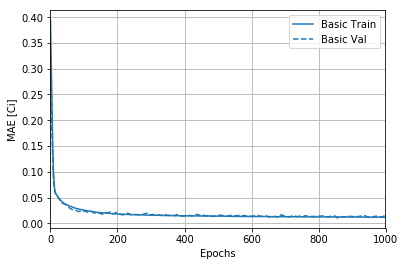

In [23]:
# The patience parameter is the amount of epochs to check for improvement
history = model_50_1_50.fit(normed_train_Am_df_50, normed_train_Ci_df_50,
  epochs=EPOCHS, validation_split = 0.1, verbose=0,
  callbacks=[tfdocs.modeling.EpochDots()])
plotter.plot({'Basic': history}, metric = "mae")
# plt.ylim([0, 1])
plt.ylabel('MAE [Ci]')
plt.show()

In [24]:
loss_50_1_50, mae_50_1_50, mse_50_1_50 = \
model_50_1_50.evaluate(normed_test_Am_df_50, normed_test_Ci_df_50, verbose=2)

200/200 - 0s - loss: 4.7465e-04 - mae: 0.0159 - mse: 4.7465e-04


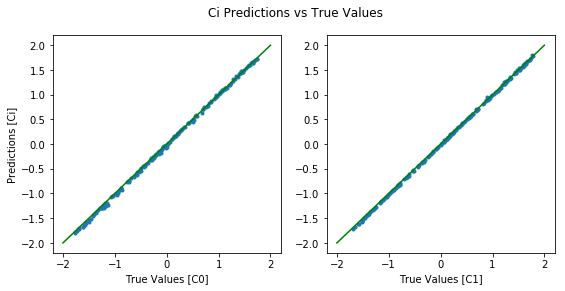

In [25]:
test_predictions_50_1_50 = model_50_1_50.predict(normed_test_Am_df_50)
plot_predict(test_predictions_50_1_50, normed_test_Ci_df_50, lims=[-2,2])

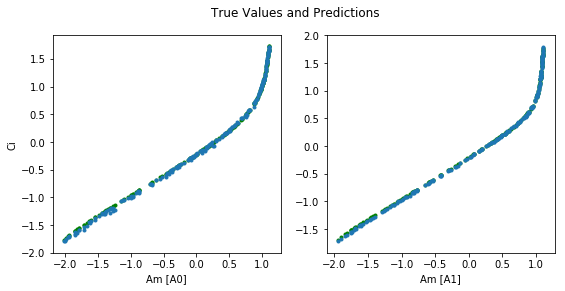

In [26]:
plot_true_and_pred(normed_test_Ci_df_50, test_predictions_50_1_50, normed_test_Am_df_50)

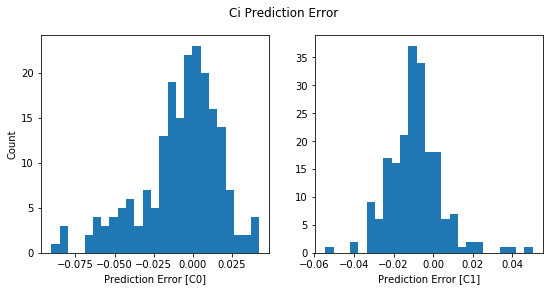

In [27]:
error_50_1_50 = test_predictions_50_1_50 - normed_test_Ci_df_50
plot_error_hist(error_50_1_50)

In [28]:
# Scaled MAE
scaled_mae_50_1_50 =error_50_1_50.abs().mean()*train_Ci_stats_50['std']
print(scaled_mae_50_1_50)

C0    8.004988e-09
C1    5.522054e-09
dtype: float64


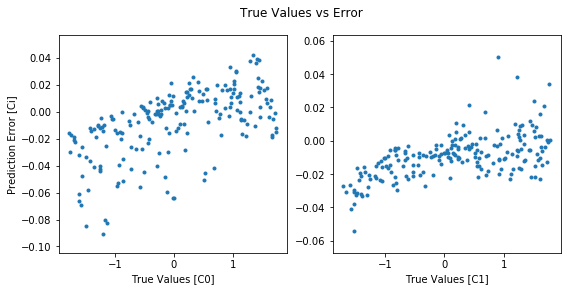

In [29]:
plot_true_v_error(normed_test_Ci_df_50, error_50_1_50)

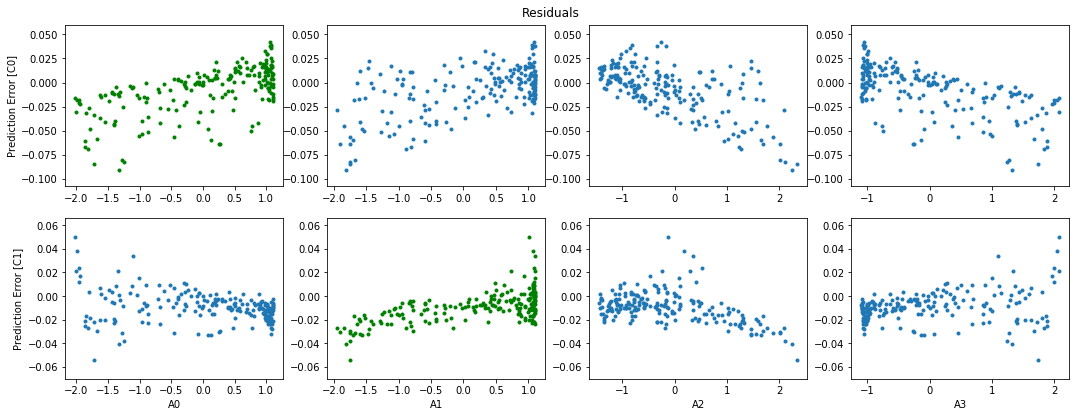

In [30]:
plot_residuals(normed_test_Am_df_50, error_50_1_50, green_list=[(0,0),(1,1),(2,2),(3,3)])

In [31]:
loss_50_1_50L, mae_50_1_50L, mse_50_1_50L = \
model_50_1_50.evaluate(large_normed_test_Am_df_50, large_normed_test_Ci_df_50, \
                        verbose=2)

1200/1200 - 0s - loss: 5.8347e-04 - mae: 0.0174 - mse: 5.8347e-04


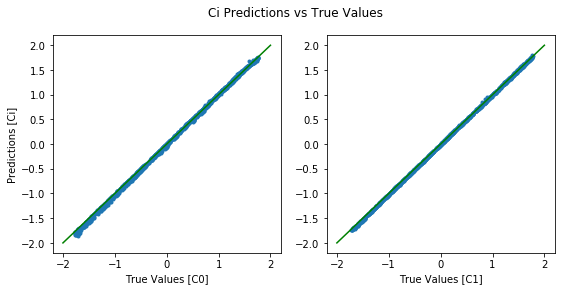

In [32]:
test_predictions_50_1_50L = model_50_1_50.predict(large_normed_test_Am_df_50)
plot_predict(test_predictions_50_1_50L, large_normed_test_Ci_df_50, lims=[-2,2])

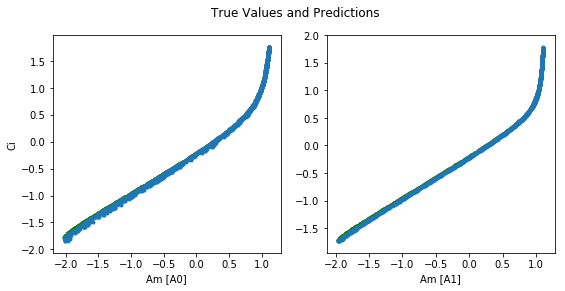

In [33]:
plot_true_and_pred(large_normed_test_Ci_df_50, test_predictions_50_1_50L, \
                   large_normed_test_Am_df_50)

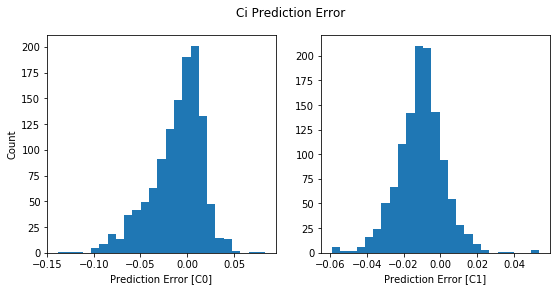

In [34]:
error_50_1_50L = test_predictions_50_1_50L - large_normed_test_Ci_df_50
plot_error_hist(error_50_1_50L)

In [35]:
# Scaled MAE
scaled_mae_50_1_50L = error_50_1_50L.abs().mean()*train_Ci_stats_50['std']
print(scaled_mae_50_1_50L)

C0    9.129170e-09
C1    5.693261e-09
dtype: float64


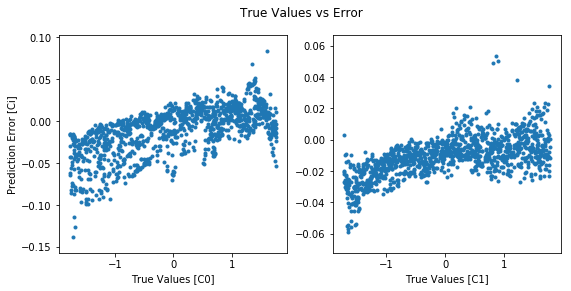

In [36]:
plot_true_v_error(large_normed_test_Ci_df_50, error_50_1_50L)

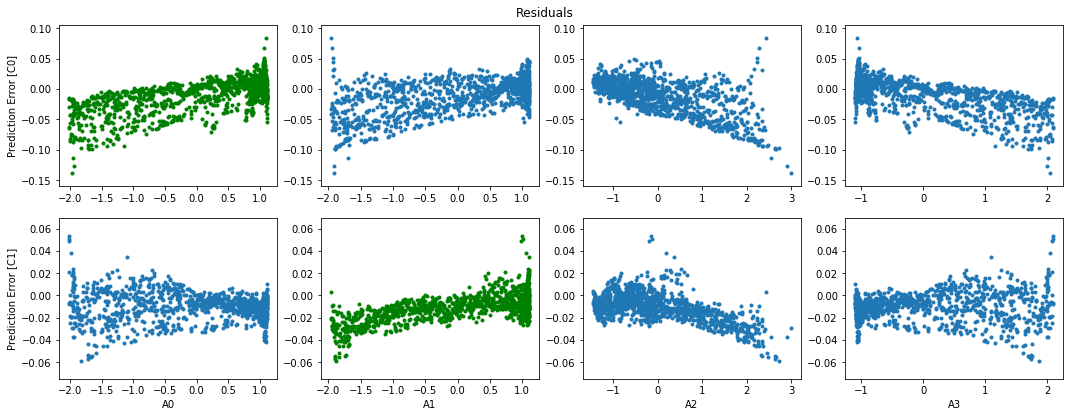

In [37]:
plot_residuals(large_normed_test_Am_df_50, error_50_1_50L, \
               green_list=[(0,0),(1,1),(2,2),(3,3)])

Now let's try 500 samples

In [38]:
train_Am_df_25, train_Ci_df_25, test_Am_df_25, test_Ci_df_25, large_test_Am_df_25, \
        large_test_Ci_df_25 = subset(Am_df, Ci_df, 0.25, 0.8)

In [39]:
# Normalize data
train_Am_stats_25 = get_stats(train_Am_df_25)
normed_train_Am_df_25 = Z_normalize_data(train_Am_df_25, train_Am_stats_25)
normed_test_Am_df_25 = Z_normalize_data(test_Am_df_25, train_Am_stats_25)
large_normed_test_Am_df_25 = Z_normalize_data(large_test_Am_df_25, train_Am_stats_25)
train_Ci_stats_25 = get_stats(train_Ci_df_25)
normed_train_Ci_df_25 = Z_normalize_data(train_Ci_df_25, train_Ci_stats_25)
normed_test_Ci_df_25 = Z_normalize_data(test_Ci_df_25, train_Ci_stats_25)
large_normed_test_Ci_df_25 = Z_normalize_data(large_test_Ci_df_25, train_Ci_stats_25)

In [40]:
model_50_1_25 = build_model(50,1,"relu")


Epoch: 0, loss:0.8009,  mae:0.7415,  mse:0.8009,  val_loss:0.5283,  val_mae:0.6097,  val_mse:0.5283,  
....................................................................................................
Epoch: 100, loss:0.0035,  mae:0.0357,  mse:0.0035,  val_loss:0.0035,  val_mae:0.0393,  val_mse:0.0035,  
....................................................................................................
Epoch: 200, loss:0.0017,  mae:0.0250,  mse:0.0017,  val_loss:0.0017,  val_mae:0.0260,  val_mse:0.0017,  
....................................................................................................
Epoch: 300, loss:0.0010,  mae:0.0208,  mse:0.0010,  val_loss:0.0008,  val_mae:0.0199,  val_mse:0.0008,  
....................................................................................................
Epoch: 400, loss:0.0008,  mae:0.0167,  mse:0.0008,  val_loss:0.0012,  val_mae:0.0246,  val_mse:0.0012,  
........................................................................

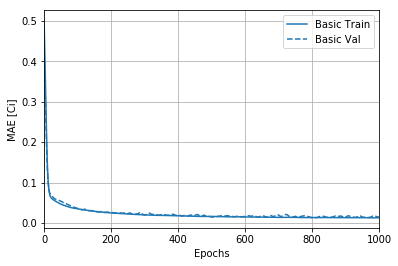

In [41]:
# The patience parameter is the amount of epochs to check for improvement
history = model_50_1_25.fit(normed_train_Am_df_25, normed_train_Ci_df_25,
  epochs=EPOCHS, validation_split = 0.1, verbose=0,
  callbacks=[tfdocs.modeling.EpochDots()])
plotter.plot({'Basic': history}, metric = "mae")
# plt.ylim([0, 1])
plt.ylabel('MAE [Ci]')
plt.show()

In [42]:
loss_50_1_25, mae_50_1_25, mse_50_1_25 = \
model_50_1_25.evaluate(normed_test_Am_df_25, normed_test_Ci_df_25, verbose=2)

100/100 - 0s - loss: 0.0013 - mae: 0.0224 - mse: 0.0013


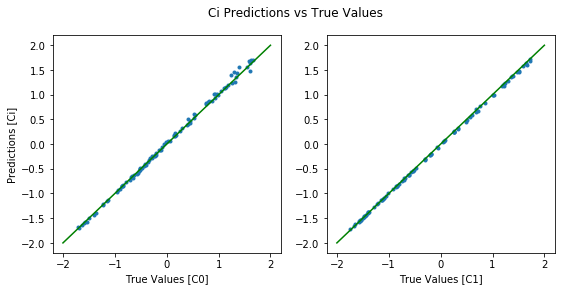

In [43]:
test_predictions_50_1_25 = model_50_1_25.predict(normed_test_Am_df_25)
plot_predict(test_predictions_50_1_25, normed_test_Ci_df_25, lims=[-2,2])

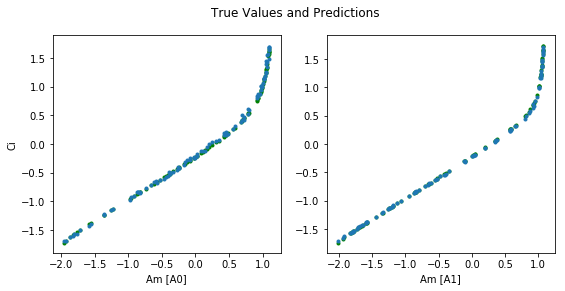

In [44]:
plot_true_and_pred(normed_test_Ci_df_25, test_predictions_50_1_25, normed_test_Am_df_25)

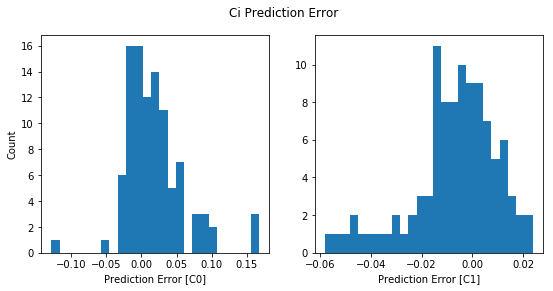

In [45]:
error_50_1_25 = test_predictions_50_1_25 - normed_test_Ci_df_25
plot_error_hist(error_50_1_25)

In [46]:
# Scaled MAE
scaled_mae_50_1_25 = error_50_1_25.abs().mean()*train_Ci_stats_25['std']
print(scaled_mae_50_1_25)

C0    1.371808e-08
C1    5.576608e-09
dtype: float64


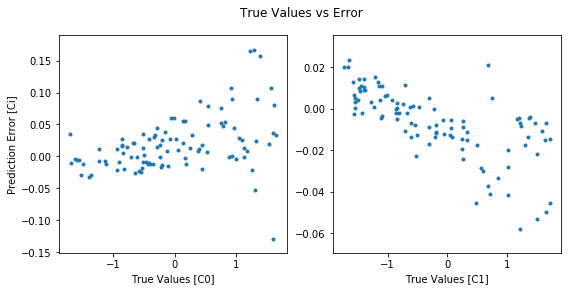

In [47]:
plot_true_v_error(normed_test_Ci_df_25, error_50_1_25)

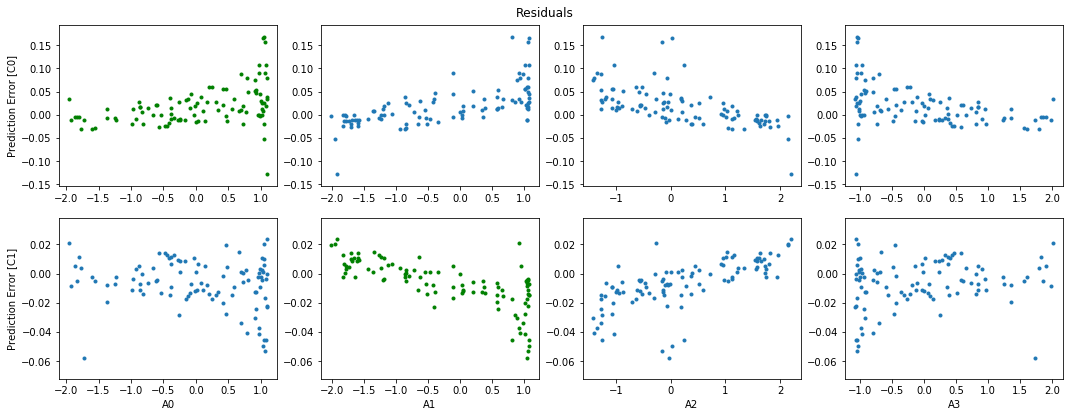

In [48]:
plot_residuals(normed_test_Am_df_25, error_50_1_25, green_list=[(0,0),(1,1),(2,2),(3,3)])

In [49]:
loss_50_1_25L, mae_50_1_25L, mse_50_1_25L = \
model_50_1_25.evaluate(large_normed_test_Am_df_25, large_normed_test_Ci_df_25, \
                        verbose=2)

1600/1600 - 0s - loss: 0.0019 - mae: 0.0281 - mse: 0.0019


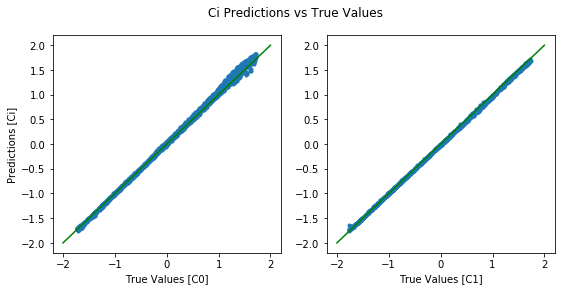

In [50]:
test_predictions_50_1_25L = model_50_1_25.predict(large_normed_test_Am_df_25)
plot_predict(test_predictions_50_1_25L, large_normed_test_Ci_df_25, lims=[-2,2])

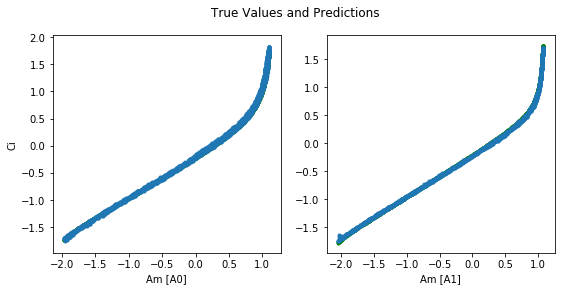

In [51]:
plot_true_and_pred(large_normed_test_Ci_df_25, test_predictions_50_1_25L, \
                   large_normed_test_Am_df_25)

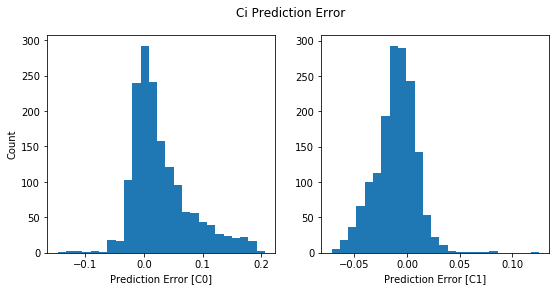

In [52]:
error_50_1_25L = test_predictions_50_1_25L - large_normed_test_Ci_df_25
plot_error_hist(error_50_1_25L)

In [53]:
# Scaled MAE
scaled_mae_50_1_25L = error_50_1_25L.abs().mean()*train_Ci_stats_25['std']
print(scaled_mae_50_1_25L)

C0    1.713188e-08
C1    7.086943e-09
dtype: float64


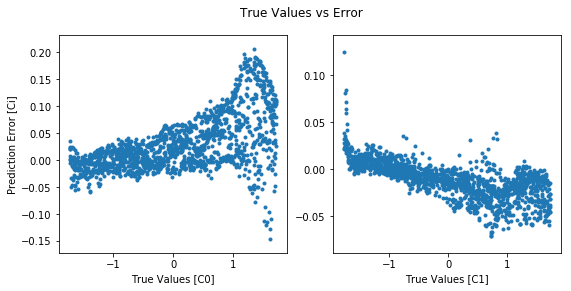

In [54]:
plot_true_v_error(large_normed_test_Ci_df_25, error_50_1_25L)

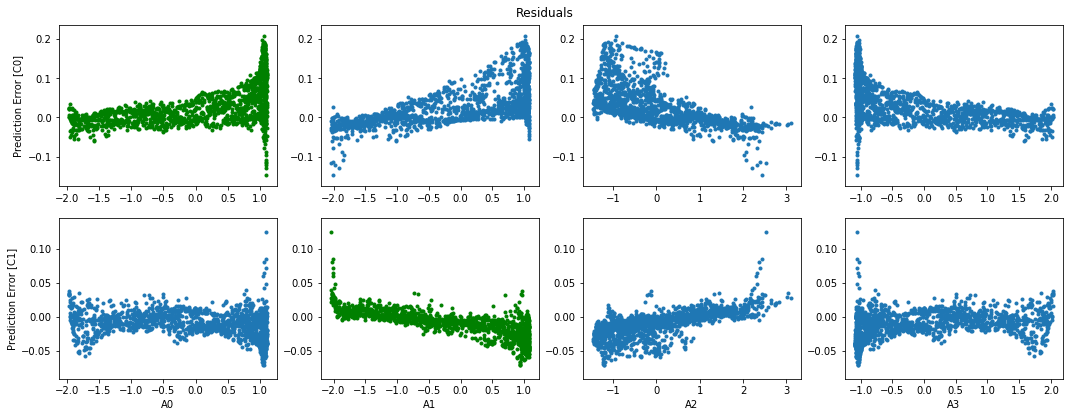

In [55]:
plot_residuals(large_normed_test_Am_df_25, error_50_1_25L, \
               green_list=[(0,0),(1,1),(2,2),(3,3)])

Now let's try looking at a data set of 250 samples

In [56]:
train_Am_df_125, train_Ci_df_125, test_Am_df_125, test_Ci_df_125, large_test_Am_df_125, \
        large_test_Ci_df_125 = subset(Am_df, Ci_df, 0.125, 0.8)

In [57]:
# Normalize data
train_Am_stats_125 = get_stats(train_Am_df_125)
normed_train_Am_df_125 = Z_normalize_data(train_Am_df_125, train_Am_stats_125)
normed_test_Am_df_125 = Z_normalize_data(test_Am_df_125, train_Am_stats_125)
large_normed_test_Am_df_125 = Z_normalize_data(large_test_Am_df_125, train_Am_stats_125)
train_Ci_stats_125 = get_stats(train_Ci_df_125)
normed_train_Ci_df_125 = Z_normalize_data(train_Ci_df_125, train_Ci_stats_125)
normed_test_Ci_df_125 = Z_normalize_data(test_Ci_df_125, train_Ci_stats_125)
large_normed_test_Ci_df_125 = Z_normalize_data(large_test_Ci_df_125, train_Ci_stats_125)

In [58]:
model_50_1_125 = build_model(50,1,"relu")


Epoch: 0, loss:0.7630,  mae:0.7515,  mse:0.7630,  val_loss:0.5101,  val_mae:0.6257,  val_mse:0.5101,  
....................................................................................................
Epoch: 100, loss:0.0062,  mae:0.0483,  mse:0.0062,  val_loss:0.0085,  val_mae:0.0529,  val_mse:0.0085,  
....................................................................................................
Epoch: 200, loss:0.0035,  mae:0.0355,  mse:0.0035,  val_loss:0.0055,  val_mae:0.0450,  val_mse:0.0055,  
....................................................................................................
Epoch: 300, loss:0.0022,  mae:0.0302,  mse:0.0022,  val_loss:0.0028,  val_mae:0.0332,  val_mse:0.0028,  
....................................................................................................
Epoch: 400, loss:0.0013,  mae:0.0230,  mse:0.0013,  val_loss:0.0021,  val_mae:0.0261,  val_mse:0.0021,  
........................................................................

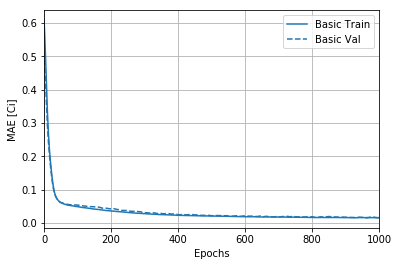

In [59]:
# The patience parameter is the amount of epochs to check for improvement
history = model_50_1_125.fit(normed_train_Am_df_125, normed_train_Ci_df_125,
  epochs=EPOCHS, validation_split = 0.1, verbose=0,
  callbacks=[tfdocs.modeling.EpochDots()])
plotter.plot({'Basic': history}, metric = "mae")
# plt.ylim([0, 1])
plt.ylabel('MAE [Ci]')
plt.show()

In [60]:
loss_50_1_125, mae_50_1_125, mse_50_1_125 = \
model_50_1_125.evaluate(normed_test_Am_df_125, normed_test_Ci_df_125, verbose=2)

50/50 - 0s - loss: 0.0023 - mae: 0.0310 - mse: 0.0023


In [61]:
# Scaled MAE
test_predictions_50_1_125 = model_50_1_125.predict(normed_test_Am_df_125)
error_50_1_125 = test_predictions_50_1_125 - normed_test_Ci_df_125
scaled_mae_50_1_125 = error_50_1_125.abs().mean()*train_Ci_stats_125['std']
print(scaled_mae_50_1_125)

C0    1.889834e-08
C1    8.095751e-09
dtype: float64


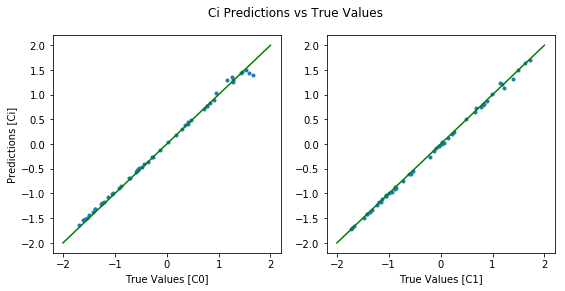

In [62]:
plot_predict(test_predictions_50_1_125, normed_test_Ci_df_125, lims=[-2,2])

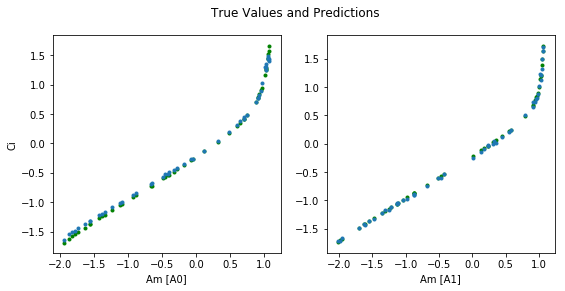

In [63]:
plot_true_and_pred(normed_test_Ci_df_125, test_predictions_50_1_125, normed_test_Am_df_125)

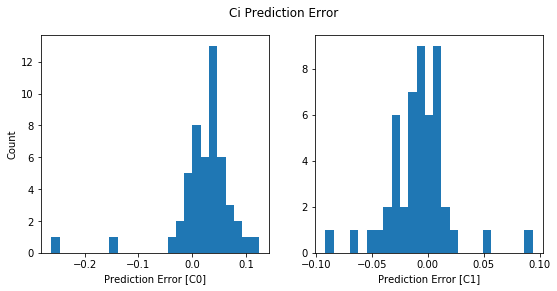

In [64]:
plot_error_hist(error_50_1_125)

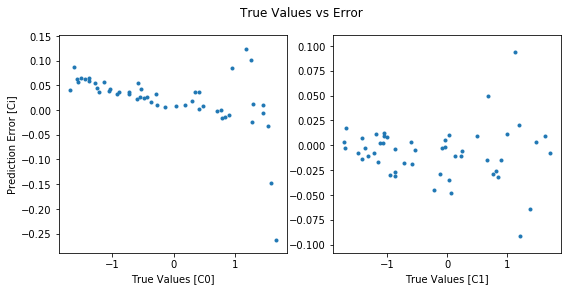

In [65]:
plot_true_v_error(normed_test_Ci_df_125, error_50_1_125)

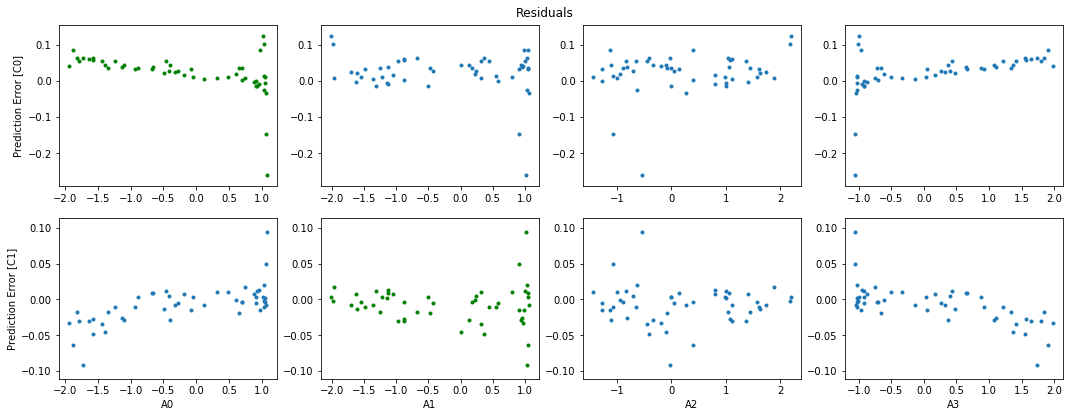

In [66]:
plot_residuals(normed_test_Am_df_125, error_50_1_125, green_list=[(0,0),(1,1),(2,2),(3,3)])

In [67]:
loss_50_1_125L, mae_50_1_125L, mse_50_1_125L = \
model_50_1_125.evaluate(large_normed_test_Am_df_125, large_normed_test_Ci_df_125, \
                        verbose=2)

1800/1800 - 0s - loss: 0.0015 - mae: 0.0266 - mse: 0.0015


In [68]:
# Scaled MAE
test_predictions_50_1_125L = model_50_1_125.predict(large_normed_test_Am_df_125)
error_50_1_125L = test_predictions_50_1_125L - large_normed_test_Ci_df_125
scaled_mae_50_1_125L = error_50_1_125L.abs().mean()*train_Ci_stats_125['std']
print(scaled_mae_50_1_125L)

C0    1.632401e-08
C1    6.885435e-09
dtype: float64


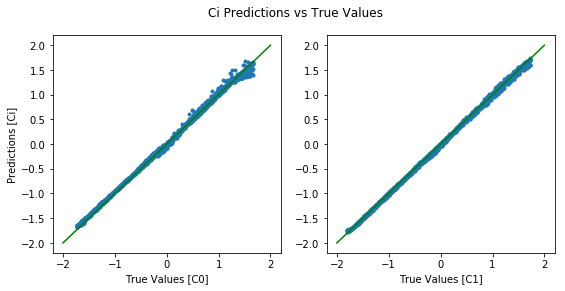

In [69]:
plot_predict(test_predictions_50_1_125L, large_normed_test_Ci_df_125, lims=[-2,2])

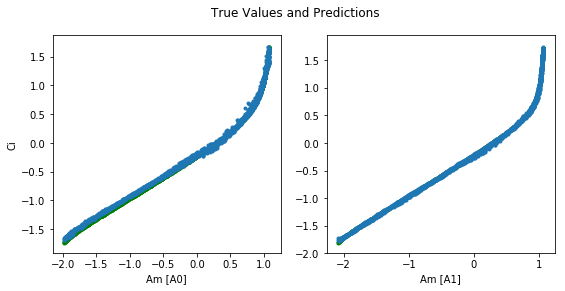

In [70]:
plot_true_and_pred(large_normed_test_Ci_df_125, test_predictions_50_1_125L, \
                   large_normed_test_Am_df_125)

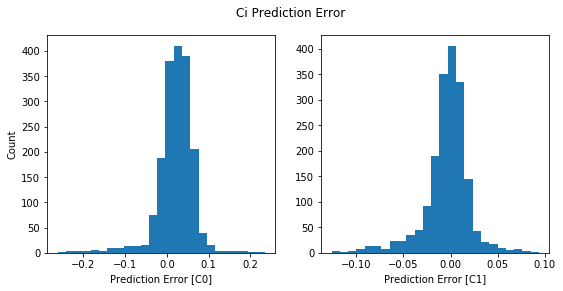

In [71]:
plot_error_hist(error_50_1_125L)

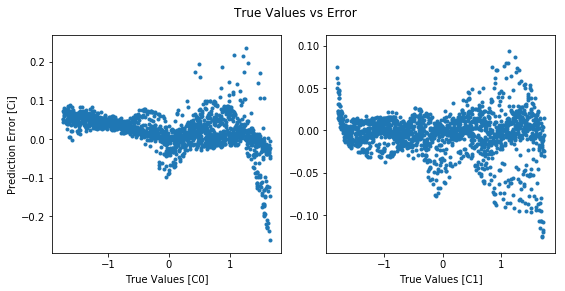

In [72]:
plot_true_v_error(large_normed_test_Ci_df_125, error_50_1_125L)

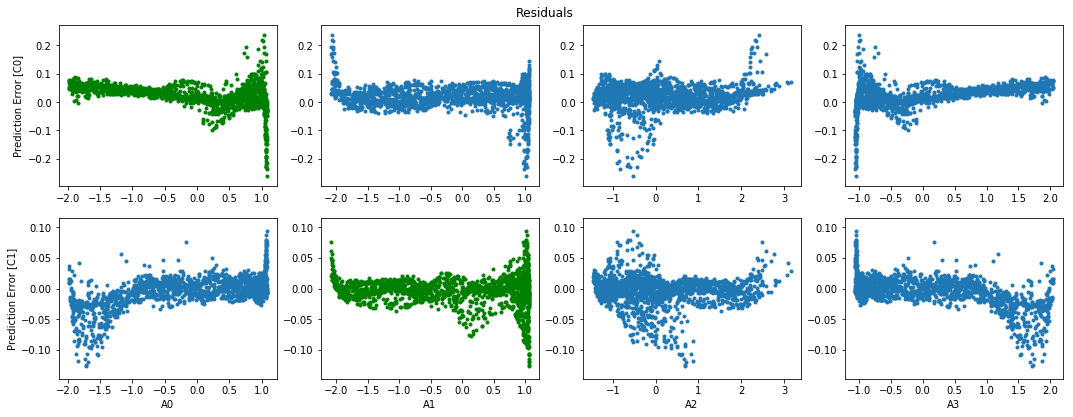

In [73]:
plot_residuals(large_normed_test_Am_df_125, error_50_1_125L, \
               green_list=[(0,0),(1,1),(2,2),(3,3)])

Now let's try 125 samples.

In [74]:
train_Am_df_05, train_Ci_df_05, test_Am_df_05, test_Ci_df_05, large_test_Am_df_05, \
        large_test_Ci_df_05 = subset(Am_df, Ci_df, 0.0625, 0.8)

In [75]:
# Normalize data
train_Am_stats_05 = get_stats(train_Am_df_05)
normed_train_Am_df_05 = Z_normalize_data(train_Am_df_05, train_Am_stats_05)
normed_test_Am_df_05 = Z_normalize_data(test_Am_df_05, train_Am_stats_05)
large_normed_test_Am_df_05 = Z_normalize_data(large_test_Am_df_05, train_Am_stats_05)
train_Ci_stats_05 = get_stats(train_Ci_df_05)
normed_train_Ci_df_05 = Z_normalize_data(train_Ci_df_05, train_Ci_stats_05)
normed_test_Ci_df_05 = Z_normalize_data(test_Ci_df_05, train_Ci_stats_05)
large_normed_test_Ci_df_05 = Z_normalize_data(large_test_Ci_df_05, train_Ci_stats_05)

In [76]:
model_50_1_05 = build_model(50,1,"relu")


Epoch: 0, loss:1.0776,  mae:0.8775,  mse:1.0776,  val_loss:0.8133,  val_mae:0.7884,  val_mse:0.8133,  
....................................................................................................
Epoch: 100, loss:0.0084,  mae:0.0569,  mse:0.0084,  val_loss:0.0059,  val_mae:0.0498,  val_mse:0.0059,  
....................................................................................................
Epoch: 200, loss:0.0045,  mae:0.0408,  mse:0.0045,  val_loss:0.0032,  val_mae:0.0353,  val_mse:0.0032,  
....................................................................................................
Epoch: 300, loss:0.0028,  mae:0.0331,  mse:0.0028,  val_loss:0.0015,  val_mae:0.0266,  val_mse:0.0015,  
....................................................................................................
Epoch: 400, loss:0.0020,  mae:0.0280,  mse:0.0020,  val_loss:0.0008,  val_mae:0.0198,  val_mse:0.0008,  
........................................................................

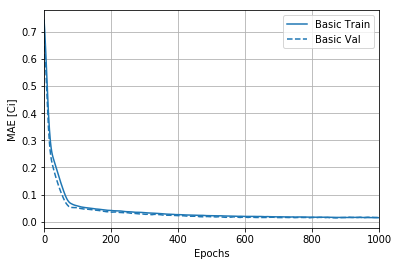

In [77]:
# The patience parameter is the amount of epochs to check for improvement
history = model_50_1_05.fit(normed_train_Am_df_05, normed_train_Ci_df_05,
  epochs=EPOCHS, validation_split = 0.1, verbose=0,
  callbacks=[tfdocs.modeling.EpochDots()])
plotter.plot({'Basic': history}, metric = "mae")
plt.ylabel('MAE [Ci]')
plt.show()

In [78]:
loss_50_1_05, mae_50_1_05, mse_50_1_05 = \
model_50_1_05.evaluate(normed_test_Am_df_05, normed_test_Ci_df_05, verbose=2)

25/25 - 0s - loss: 0.0042 - mae: 0.0364 - mse: 0.0042


In [79]:
# Scaled MAE
test_predictions_50_1_05 = model_50_1_05.predict(normed_test_Am_df_05)
error_50_1_05 = test_predictions_50_1_05 - normed_test_Ci_df_05
scaled_mae_50_1_05 = error_50_1_05.abs().mean()*train_Ci_stats_05['std']
print(scaled_mae_50_1_05)

C0    1.949053e-08
C1    1.094216e-08
dtype: float64


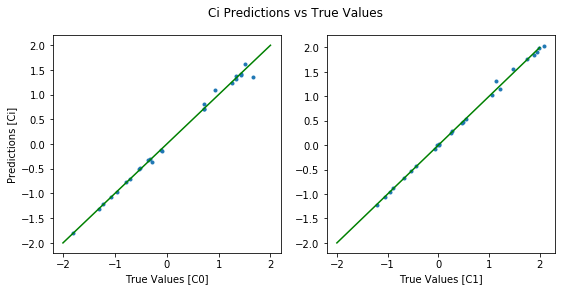

In [80]:
plot_predict(test_predictions_50_1_05, normed_test_Ci_df_05, lims=[-2,2])

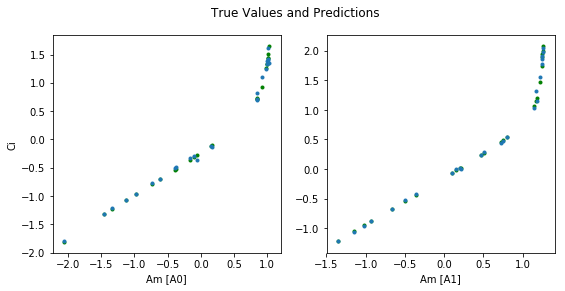

In [81]:
plot_true_and_pred(normed_test_Ci_df_05, test_predictions_50_1_05, normed_test_Am_df_05)

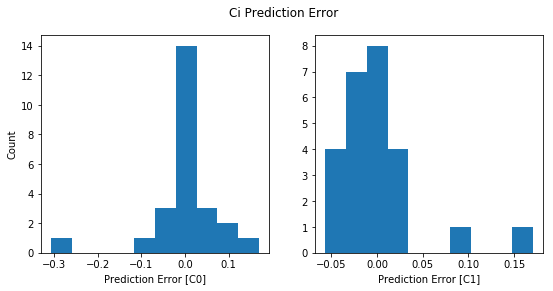

In [82]:
plot_error_hist(error_50_1_05, bins=10)

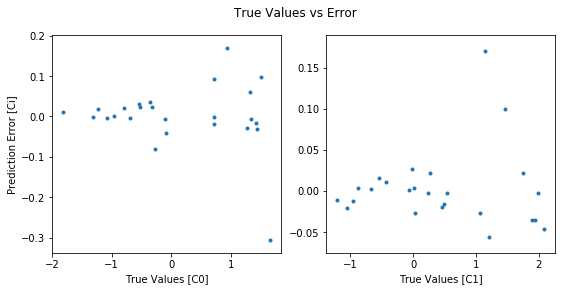

In [83]:
plot_true_v_error(normed_test_Ci_df_05, error_50_1_05)

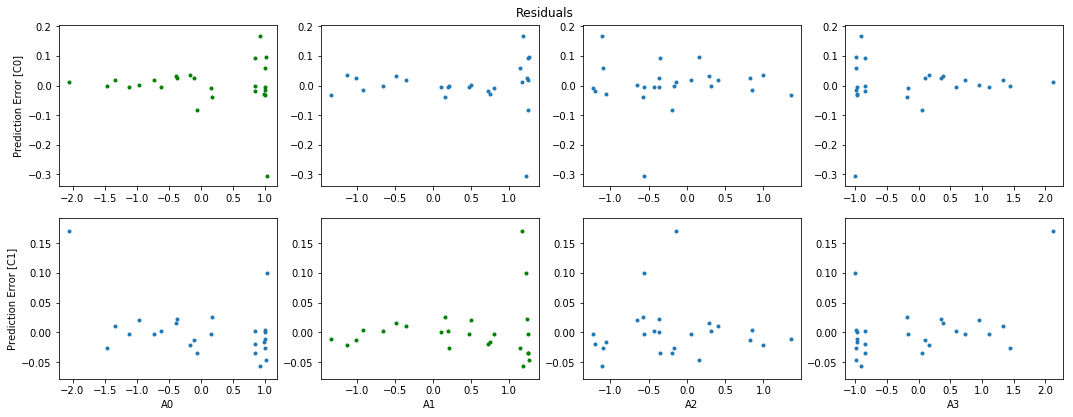

In [84]:
plot_residuals(normed_test_Am_df_05, error_50_1_05, green_list=[(0,0),(1,1),(2,2),(3,3)])

In [85]:
loss_50_1_05L, mae_50_1_05L, mse_50_1_05L = \
model_50_1_05.evaluate(large_normed_test_Am_df_05, large_normed_test_Ci_df_05, \
                        verbose=2)

1900/1900 - 0s - loss: 0.0021 - mae: 0.0289 - mse: 0.0021


In [86]:
# Scaled MAE
test_predictions_50_1_05L = model_50_1_05.predict(large_normed_test_Am_df_05)
error_50_1_05L = test_predictions_50_1_05L - large_normed_test_Ci_df_05
scaled_mae_50_1_05L = error_50_1_05L.abs().mean()*train_Ci_stats_05['std']
print(scaled_mae_50_1_05L)

C0    1.598323e-08
C1    8.230278e-09
dtype: float64


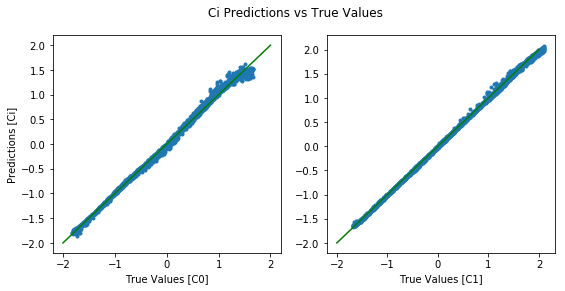

In [87]:
plot_predict(test_predictions_50_1_05L, large_normed_test_Ci_df_05, lims=[-2,2])

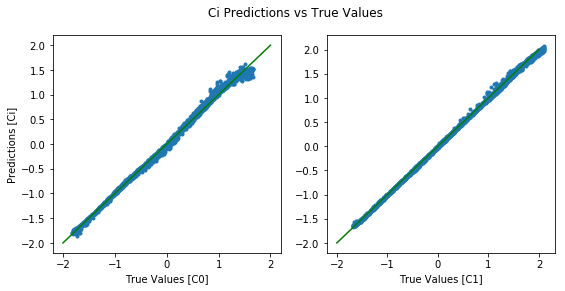

In [88]:
plot_predict(test_predictions_50_1_05L, large_normed_test_Ci_df_05, lims=[-2,2])

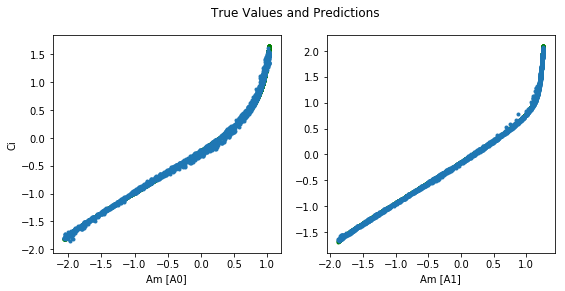

In [89]:
plot_true_and_pred(large_normed_test_Ci_df_05, test_predictions_50_1_05L, \
                   large_normed_test_Am_df_05)

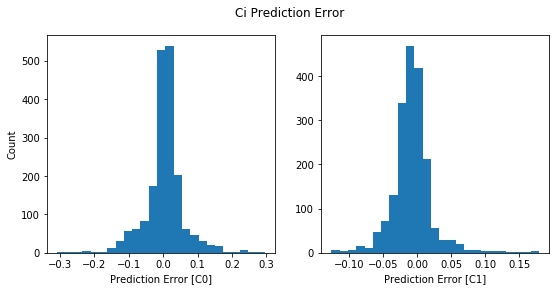

In [90]:
plot_error_hist(error_50_1_05L)

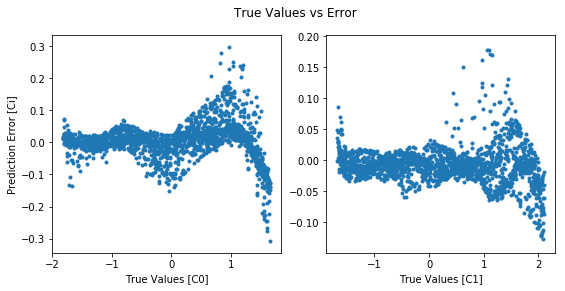

In [91]:
plot_true_v_error(large_normed_test_Ci_df_05, error_50_1_05L)

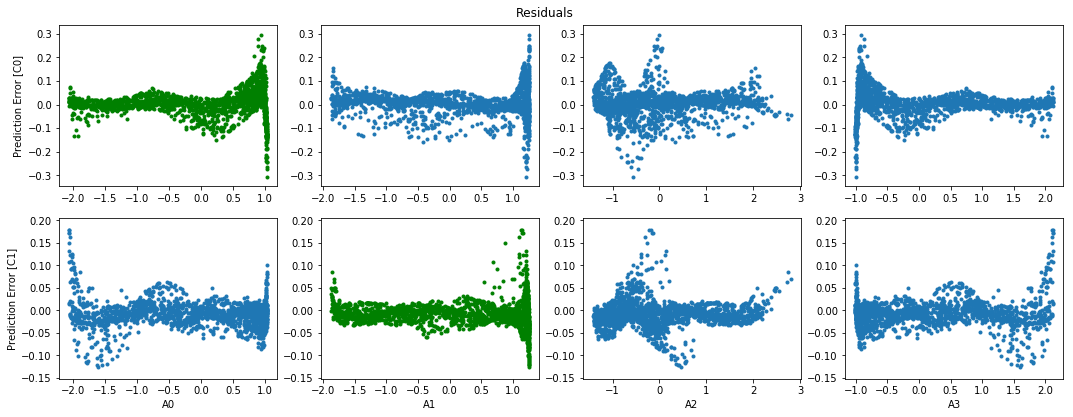

In [92]:
plot_residuals(large_normed_test_Am_df_05, error_50_1_05L, \
               green_list=[(0,0),(1,1),(2,2),(3,3)])

Now let's try 50 samples

In [93]:
train_Am_df_025, train_Ci_df_025, test_Am_df_025, test_Ci_df_025, large_test_Am_df_025, \
        large_test_Ci_df_025 = subset(Am_df, Ci_df, 0.025, 0.8)

In [94]:
# Normalize data
train_Am_stats_025 = get_stats(train_Am_df_025)
normed_train_Am_df_025 = Z_normalize_data(train_Am_df_025, train_Am_stats_025)
normed_test_Am_df_025 = Z_normalize_data(test_Am_df_025, train_Am_stats_025)
large_normed_test_Am_df_025 = Z_normalize_data(large_test_Am_df_025, train_Am_stats_025)
train_Ci_stats_025 = get_stats(train_Ci_df_025)
normed_train_Ci_df_025 = Z_normalize_data(train_Ci_df_025, train_Ci_stats_025)
normed_test_Ci_df_025 = Z_normalize_data(test_Ci_df_025, train_Ci_stats_025)
large_normed_test_Ci_df_025 = Z_normalize_data(large_test_Ci_df_025, train_Ci_stats_025)

In [95]:
model_50_1_025 = build_model(50,1,"relu")


Epoch: 0, loss:0.9658,  mae:0.8513,  mse:0.9658,  val_loss:0.3842,  val_mae:0.4710,  val_mse:0.3842,  
....................................................................................................
Epoch: 100, loss:0.0290,  mae:0.1192,  mse:0.0290,  val_loss:0.0331,  val_mae:0.1466,  val_mse:0.0331,  
....................................................................................................
Epoch: 200, loss:0.0102,  mae:0.0577,  mse:0.0102,  val_loss:0.0009,  val_mae:0.0267,  val_mse:0.0009,  
....................................................................................................
Epoch: 300, loss:0.0077,  mae:0.0481,  mse:0.0077,  val_loss:0.0023,  val_mae:0.0405,  val_mse:0.0023,  
....................................................................................................
Epoch: 400, loss:0.0067,  mae:0.0456,  mse:0.0067,  val_loss:0.0016,  val_mae:0.0309,  val_mse:0.0016,  
........................................................................

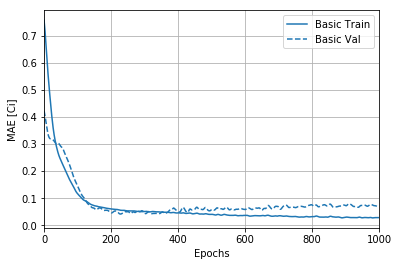

In [96]:
# The patience parameter is the amount of epochs to check for improvement
history = model_50_1_025.fit(normed_train_Am_df_025, normed_train_Ci_df_025,
  epochs=EPOCHS, validation_split = 0.1, verbose=0,
  callbacks=[tfdocs.modeling.EpochDots()])
plotter.plot({'Basic': history}, metric = "mae")
# plt.ylim([0, 1])
plt.ylabel('MAE [Ci]')
plt.show()

In [97]:
loss_50_1_025, mae_50_1_025, mse_50_1_025 = \
model_50_1_025.evaluate(normed_test_Am_df_025, normed_test_Ci_df_025, verbose=2)

10/10 - 0s - loss: 0.0089 - mae: 0.0713 - mse: 0.0089


In [98]:
# Scaled MAE
test_predictions_50_1_025 = model_50_1_025.predict(normed_test_Am_df_025)
error_50_1_025 = test_predictions_50_1_025 - normed_test_Ci_df_025
scaled_mae_50_1_025 = error_50_1_025.abs().mean()*train_Ci_stats_025['std']
print(scaled_mae_50_1_025)

C0    4.589173e-08
C1    1.926439e-08
dtype: float64


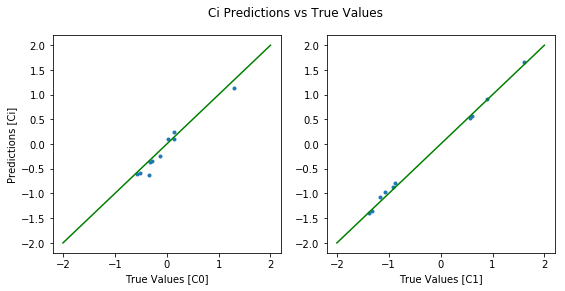

In [99]:
plot_predict(test_predictions_50_1_025, normed_test_Ci_df_025, lims=[-2,2])

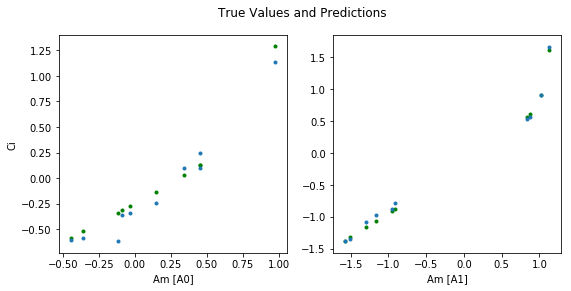

In [100]:
plot_true_and_pred(normed_test_Ci_df_025, test_predictions_50_1_025, normed_test_Am_df_025)

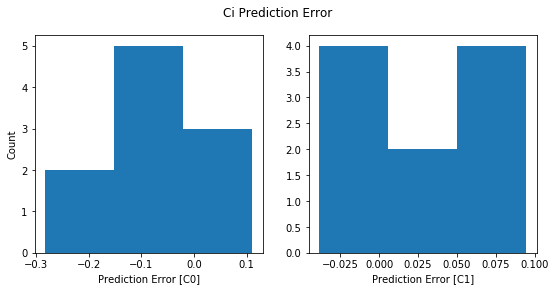

In [101]:
plot_error_hist(error_50_1_025,bins=3)

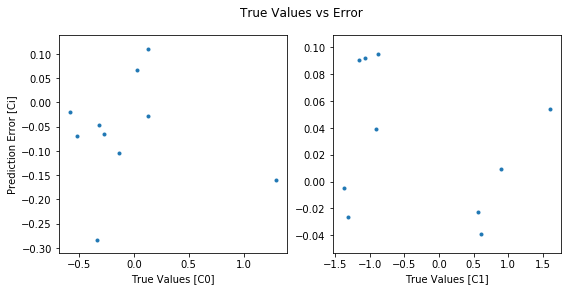

In [102]:
plot_true_v_error(normed_test_Ci_df_025, error_50_1_025)

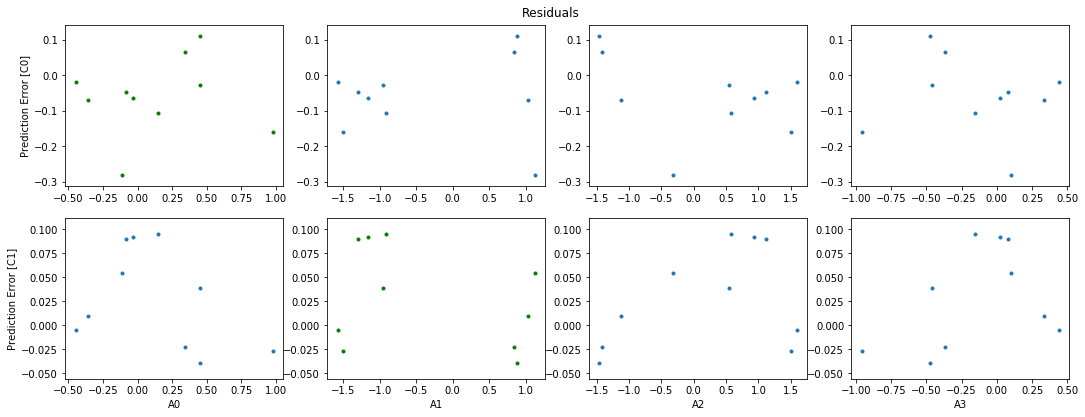

In [103]:
plot_residuals(normed_test_Am_df_025, error_50_1_025, green_list=[(0,0),(1,1),(2,2),(3,3)])

In [104]:
loss_50_1_025L, mae_50_1_025L, mse_50_1_025L = \
model_50_1_025.evaluate(large_normed_test_Am_df_025, large_normed_test_Ci_df_025, \
                        verbose=2)

1960/1960 - 0s - loss: 0.0123 - mae: 0.0710 - mse: 0.0123


In [105]:
# Scaled MAE
test_predictions_50_1_025L = model_50_1_025.predict(large_normed_test_Am_df_025)
error_50_1_025L = test_predictions_50_1_025L - large_normed_test_Ci_df_025
scaled_mae_50_1_025L = error_50_1_025L.abs().mean()*train_Ci_stats_025['std']
print(scaled_mae_50_1_025L)

C0    4.852192e-08
C1    1.679753e-08
dtype: float64


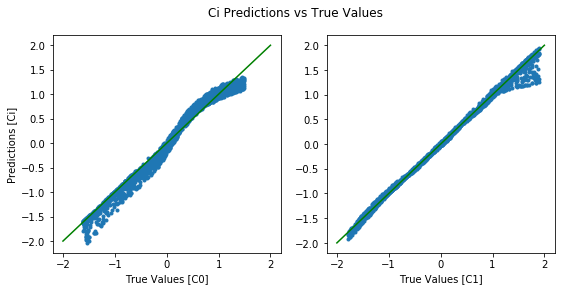

In [106]:
plot_predict(test_predictions_50_1_025L, large_normed_test_Ci_df_025, lims=[-2,2])

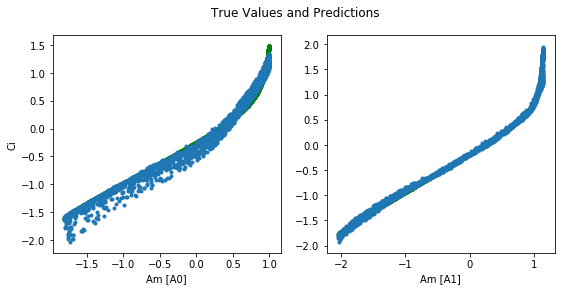

In [107]:
plot_true_and_pred(large_normed_test_Ci_df_025, test_predictions_50_1_025L, \
                   large_normed_test_Am_df_025)

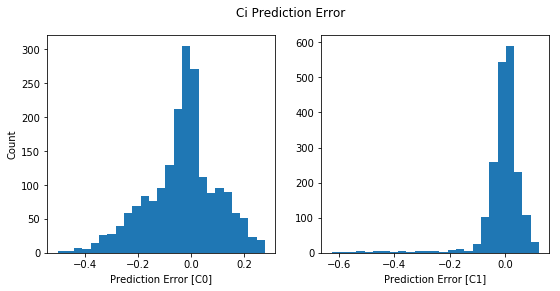

In [108]:
plot_error_hist(error_50_1_025L)

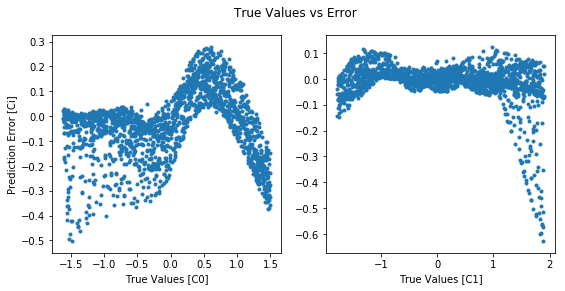

In [109]:
plot_true_v_error(large_normed_test_Ci_df_025, error_50_1_025L)

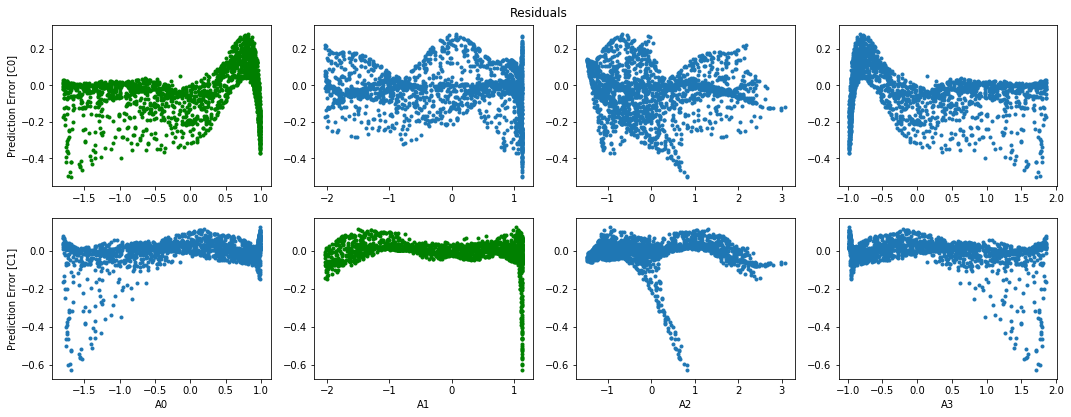

In [110]:
plot_residuals(large_normed_test_Am_df_025, error_50_1_025L, \
               green_list=[(0,0),(1,1),(2,2),(3,3)])

Now let's try 25 samples

In [111]:
train_Am_df_0125, train_Ci_df_0125, test_Am_df_0125, test_Ci_df_0125, large_test_Am_df_0125, \
        large_test_Ci_df_0125 = subset(Am_df, Ci_df, 0.0125, 0.8)

In [112]:
# Normalize data
train_Am_stats_0125 = get_stats(train_Am_df_0125)
normed_train_Am_df_0125 = Z_normalize_data(train_Am_df_0125, train_Am_stats_0125)
normed_test_Am_df_0125 = Z_normalize_data(test_Am_df_0125, train_Am_stats_0125)
large_normed_test_Am_df_0125 = Z_normalize_data(large_test_Am_df_0125, train_Am_stats_0125)
train_Ci_stats_0125 = get_stats(train_Ci_df_0125)
normed_train_Ci_df_0125 = Z_normalize_data(train_Ci_df_0125, train_Ci_stats_0125)
normed_test_Ci_df_0125 = Z_normalize_data(test_Ci_df_0125, train_Ci_stats_0125)
large_normed_test_Ci_df_0125 = Z_normalize_data(large_test_Ci_df_0125, train_Ci_stats_0125)

In [113]:
model_50_1_0125 = build_model(50,1,"relu")


Epoch: 0, loss:1.8618,  mae:1.1204,  mse:1.8618,  val_loss:1.7951,  val_mae:1.0893,  val_mse:1.7951,  
....................................................................................................
Epoch: 100, loss:0.0962,  mae:0.2185,  mse:0.0962,  val_loss:0.2483,  val_mae:0.3609,  val_mse:0.2483,  
....................................................................................................
Epoch: 200, loss:0.0071,  mae:0.0596,  mse:0.0071,  val_loss:0.1041,  val_mae:0.1897,  val_mse:0.1041,  
....................................................................................................
Epoch: 300, loss:0.0028,  mae:0.0354,  mse:0.0028,  val_loss:0.0739,  val_mae:0.1883,  val_mse:0.0739,  
....................................................................................................
Epoch: 400, loss:0.0015,  mae:0.0264,  mse:0.0015,  val_loss:0.0712,  val_mae:0.1827,  val_mse:0.0712,  
........................................................................

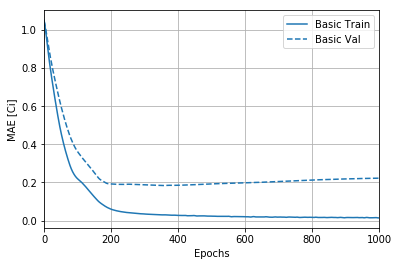

In [114]:
history = model_50_1_0125.fit(normed_train_Am_df_0125, normed_train_Ci_df_0125,
  epochs=EPOCHS, validation_split = 0.1, verbose=0,
  callbacks=[tfdocs.modeling.EpochDots()])
plotter.plot({'Basic': history}, metric = "mae")
plt.ylabel('MAE [Ci]')
plt.show()

In [115]:
loss_50_1_0125, mae_50_1_0125, mse_50_1_0125 = \
model_50_1_0125.evaluate(normed_test_Am_df_0125, normed_test_Ci_df_0125, verbose=2)

5/5 - 0s - loss: 0.0094 - mae: 0.0782 - mse: 0.0094


In [116]:
# Scaled MAE
test_predictions_50_1_0125 = model_50_1_0125.predict(normed_test_Am_df_0125)
error_50_1_0125 = test_predictions_50_1_0125 - normed_test_Ci_df_0125
scaled_mae_50_1_0125 = error_50_1_0125.abs().mean()*train_Ci_stats_0125['std']
print(scaled_mae_50_1_0125)

C0    5.016182e-08
C1    2.220225e-08
dtype: float64


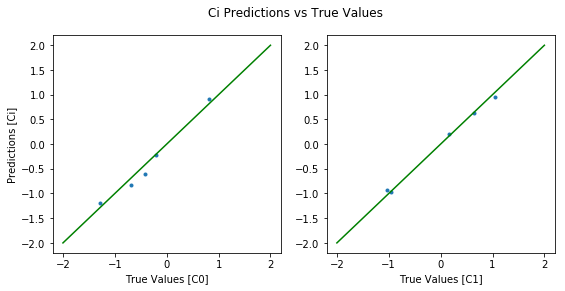

In [117]:
plot_predict(test_predictions_50_1_0125, normed_test_Ci_df_0125, lims=[-2,2])

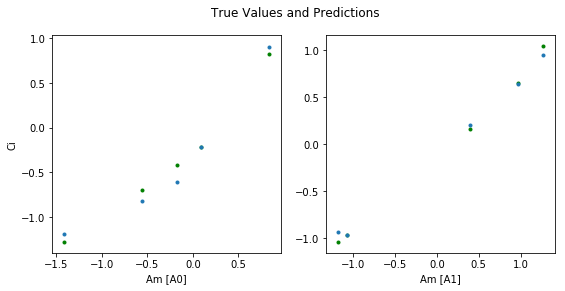

In [118]:
plot_true_and_pred(normed_test_Ci_df_0125, test_predictions_50_1_0125, normed_test_Am_df_0125)

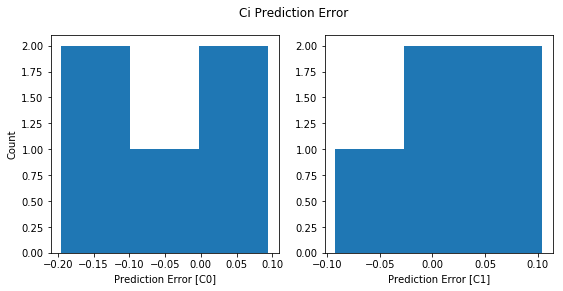

In [119]:
plot_error_hist(error_50_1_0125,bins=3)

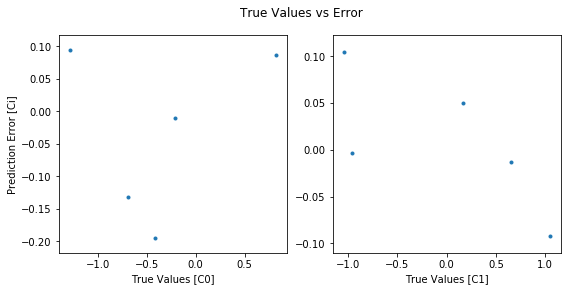

In [120]:
plot_true_v_error(normed_test_Ci_df_0125, error_50_1_0125)

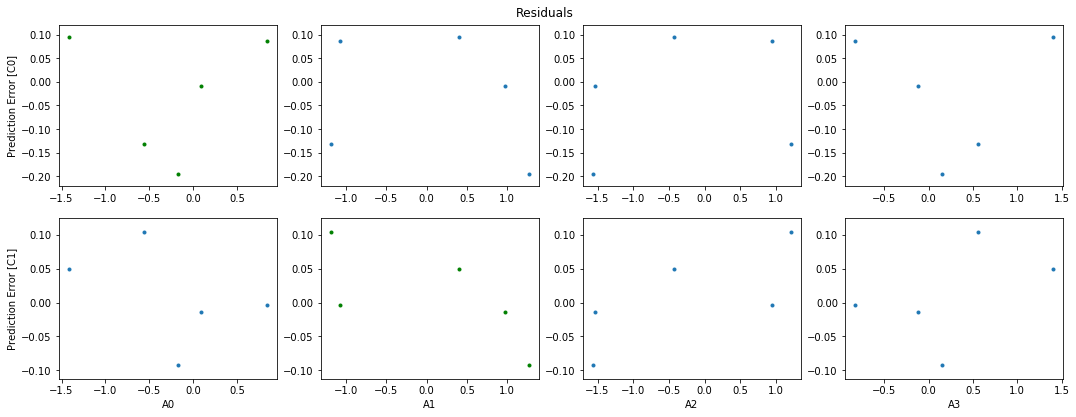

In [121]:
plot_residuals(normed_test_Am_df_0125, error_50_1_0125, green_list=[(0,0),(1,1),(2,2),(3,3)])


In [122]:
loss_50_1_0125L, mae_50_1_0125L, mse_50_1_0125L = \
model_50_1_0125.evaluate(large_normed_test_Am_df_0125, large_normed_test_Ci_df_0125, \
                        verbose=2)

1980/1980 - 0s - loss: 0.0370 - mae: 0.1254 - mse: 0.0370


In [123]:
# Scaled MAE
test_predictions_50_1_0125L = model_50_1_0125.predict(large_normed_test_Am_df_0125)
error_50_1_0125L = test_predictions_50_1_0125L - large_normed_test_Ci_df_0125
scaled_mae_50_1_0125L = error_50_1_0125L.abs().mean()*train_Ci_stats_0125['std']
print(scaled_mae_50_1_0125L)

C0    7.012950e-08
C1    4.464278e-08
dtype: float64


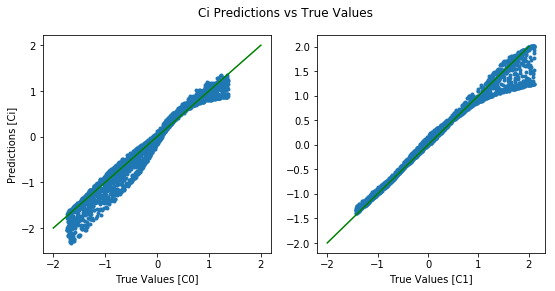

In [124]:
plot_predict(test_predictions_50_1_0125L, large_normed_test_Ci_df_0125, lims=[-2,2])

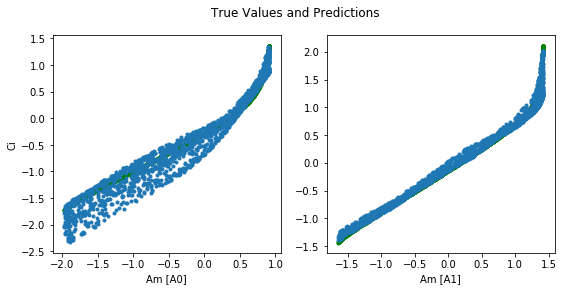

In [125]:
plot_true_and_pred(large_normed_test_Ci_df_0125, test_predictions_50_1_0125L, \
                   large_normed_test_Am_df_0125)

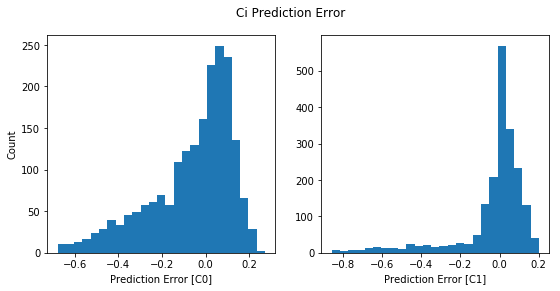

In [126]:
plot_error_hist(error_50_1_0125L)

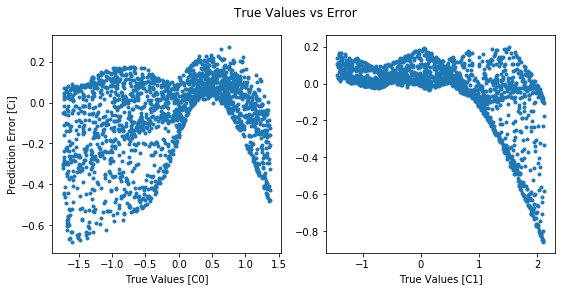

In [127]:
plot_true_v_error(large_normed_test_Ci_df_0125, error_50_1_0125L)

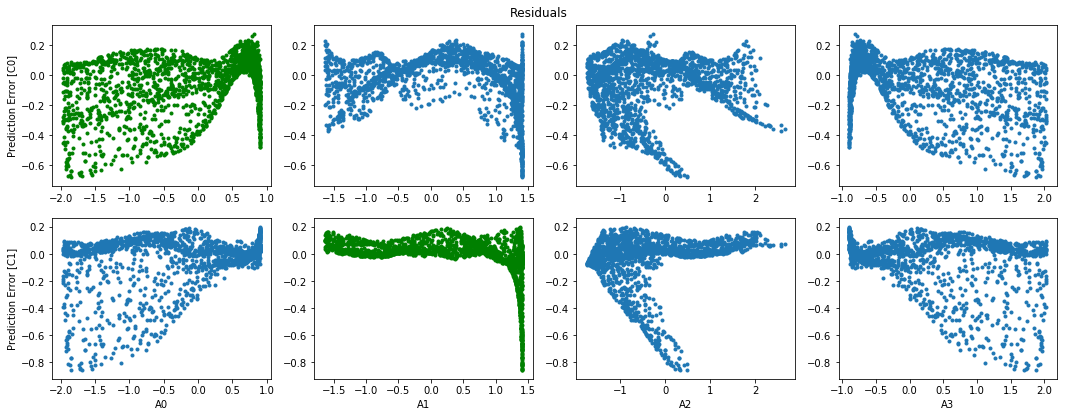

In [128]:
plot_residuals(large_normed_test_Am_df_0125, error_50_1_0125L, \
               green_list=[(0,0),(1,1),(2,2),(3,3)])

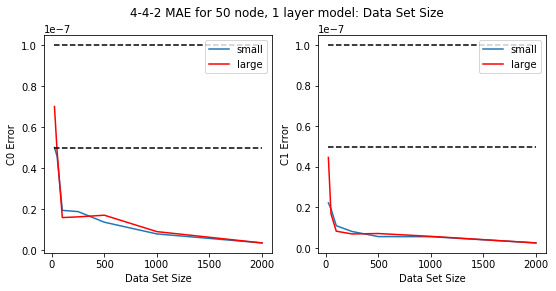

In [129]:
fig, ax = plt.subplots(1,2,figsize=(9,4))
fig.suptitle('4-4-2 MAE for 50 node, 1 layer model: Data Set Size')
for i in range(2):
    ax[i].plot([2000,1000,500,250,100, 50, 25],\
             [scaled_mae_50_1[i], scaled_mae_50_1_50[i], scaled_mae_50_1_25[i], \
              scaled_mae_50_1_125[i], scaled_mae_50_1_05[i], scaled_mae_50_1_025[i], scaled_mae_50_1_0125[i]], \
              label='small')
    ax[i].plot([2000,1000,500,250,100, 50, 25],\
             [scaled_mae_50_1[i], scaled_mae_50_1_50L[i], scaled_mae_50_1_25L[i], \
              scaled_mae_50_1_125L[i], scaled_mae_50_1_05L[i], scaled_mae_50_1_025L[i], \
              scaled_mae_50_1_0125L[i]],\
             'r', label='large')
#     ax[i].scatter([2000],[scaled_mae_50_1_mm[i]], marker='.', c='g', label='Min-Max')
    ax[i].plot([25,2000],[1e-7,1e-7],'k--')
    ax[i].plot([25,2000],[5e-8,5e-8],'k--')
    ax[i].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    ax[i].legend(loc='upper right')
    ax[i].set_xlabel('Data Set Size')
    ax[i].set_ylabel('C{} Error'.format(i))
#     ax[i].set_ylim(0,1.5e-7)

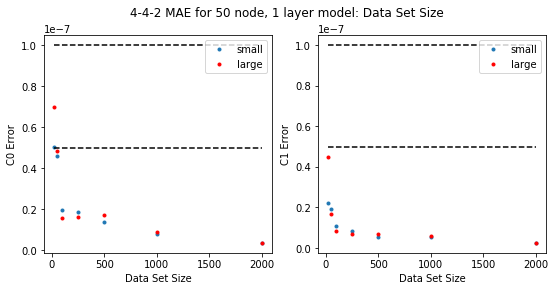

In [198]:
fig, ax = plt.subplots(1,2,figsize=(9,4))
fig.suptitle('4-4-2 MAE for 50 node, 1 layer model: Data Set Size')
for i in range(2):
    ax[i].plot([2000,1000,500,250,100, 50, 25],\
             [scaled_mae_50_1[i], scaled_mae_50_1_50[i], scaled_mae_50_1_25[i], \
              scaled_mae_50_1_125[i], scaled_mae_50_1_05[i], scaled_mae_50_1_025[i], scaled_mae_50_1_0125[i]], \
              '.', label='small')
    ax[i].plot([2000,1000,500,250,100, 50, 25],\
             [scaled_mae_50_1[i], scaled_mae_50_1_50L[i], scaled_mae_50_1_25L[i], \
              scaled_mae_50_1_125L[i], scaled_mae_50_1_05L[i], scaled_mae_50_1_025L[i], \
              scaled_mae_50_1_0125L[i]],\
             'r.', label='large')
#     ax[i].scatter([2000],[scaled_mae_50_1_mm[i]], marker='.', c='g', label='Min-Max')
    ax[i].plot([25,2000],[1e-7,1e-7],'k--')
    ax[i].plot([25,2000],[5e-8,5e-8],'k--')
    ax[i].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    ax[i].legend(loc='upper right')
    ax[i].set_xlabel('Data Set Size')
    ax[i].set_ylabel('C{} Error'.format(i))
#     ax[i].set_ylim(0,1.5e-7)

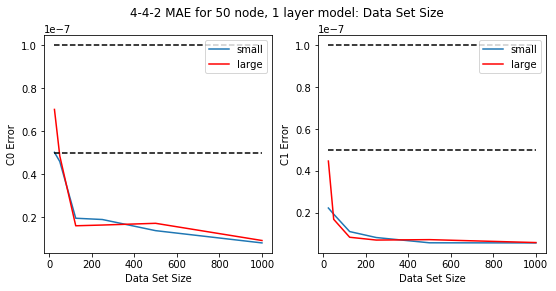

In [130]:
fig, ax = plt.subplots(1,2,figsize=(9,4))
fig.suptitle('4-4-2 MAE for 50 node, 1 layer model: Data Set Size')
for i in range(2):
    ax[i].plot([1000,500,250,125, 50, 25],\
             [scaled_mae_50_1_50[i], scaled_mae_50_1_25[i], \
              scaled_mae_50_1_125[i], scaled_mae_50_1_05[i], scaled_mae_50_1_025[i], scaled_mae_50_1_0125[i]], \
              label='small')
    ax[i].plot([1000,500,250,125, 50, 25],\
             [scaled_mae_50_1_50L[i], scaled_mae_50_1_25L[i], \
              scaled_mae_50_1_125L[i], scaled_mae_50_1_05L[i], scaled_mae_50_1_025L[i], \
              scaled_mae_50_1_0125L[i]],\
             'r', label='large')
#     ax[i].scatter([2000],[scaled_mae_50_1_mm[i]], marker='.', c='g', label='Min-Max')
    ax[i].plot([25,1000],[1e-7,1e-7],'k--')
    ax[i].plot([25,1000],[5e-8,5e-8],'k--')
    ax[i].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    ax[i].legend(loc='upper right')
    ax[i].set_xlabel('Data Set Size')
    ax[i].set_ylabel('C{} Error'.format(i))
#     ax[i].set_ylim(0,1.5e-7)

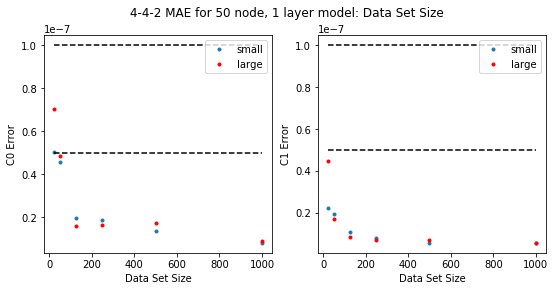

In [197]:
fig, ax = plt.subplots(1,2,figsize=(9,4))
fig.suptitle('4-4-2 MAE for 50 node, 1 layer model: Data Set Size')
for i in range(2):
    ax[i].plot([1000,500,250,125, 50, 25],\
             [scaled_mae_50_1_50[i], scaled_mae_50_1_25[i], \
              scaled_mae_50_1_125[i], scaled_mae_50_1_05[i], scaled_mae_50_1_025[i], scaled_mae_50_1_0125[i]], \
              '.', label='small')
    ax[i].plot([1000,500,250,125, 50, 25],\
             [scaled_mae_50_1_50L[i], scaled_mae_50_1_25L[i], \
              scaled_mae_50_1_125L[i], scaled_mae_50_1_05L[i], scaled_mae_50_1_025L[i], \
              scaled_mae_50_1_0125L[i]],\
             'r.', label='large')
#     ax[i].scatter([2000],[scaled_mae_50_1_mm[i]], marker='.', c='g', label='Min-Max')
    ax[i].plot([25,1000],[1e-7,1e-7],'k--')
    ax[i].plot([25,1000],[5e-8,5e-8],'k--')
    ax[i].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    ax[i].legend(loc='upper right')
    ax[i].set_xlabel('Data Set Size')
    ax[i].set_ylabel('C{} Error'.format(i))
#     ax[i].set_ylim(0,1.5e-7)

Now let's try a few different model sizes

First let's try a 20 node, 1 layer model on 1000 samples, so we can compare with the 2-2-2 system

In [131]:
model_20_1_50 = build_model(20,1,"relu")


Epoch: 0, loss:1.0566,  mae:0.8421,  mse:1.0566,  val_loss:0.7040,  val_mae:0.6883,  val_mse:0.7040,  
....................................................................................................
Epoch: 100, loss:0.0032,  mae:0.0365,  mse:0.0032,  val_loss:0.0025,  val_mae:0.0349,  val_mse:0.0025,  
....................................................................................................
Epoch: 200, loss:0.0012,  mae:0.0228,  mse:0.0012,  val_loss:0.0007,  val_mae:0.0180,  val_mse:0.0007,  
....................................................................................................
Epoch: 300, loss:0.0007,  mae:0.0172,  mse:0.0007,  val_loss:0.0006,  val_mae:0.0164,  val_mse:0.0006,  
....................................................................................................
Epoch: 400, loss:0.0005,  mae:0.0147,  mse:0.0005,  val_loss:0.0006,  val_mae:0.0165,  val_mse:0.0006,  
........................................................................

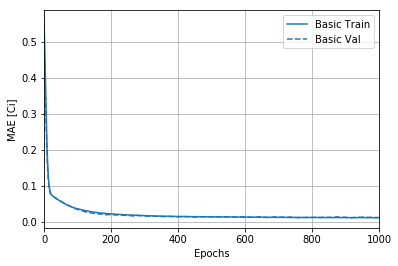

In [132]:
history = model_20_1_50.fit(normed_train_Am_df_50, normed_train_Ci_df_50,
  epochs=EPOCHS, validation_split = 0.1, verbose=0,
  callbacks=[tfdocs.modeling.EpochDots()])
plotter.plot({'Basic': history}, metric = "mae")
plt.ylabel('MAE [Ci]')
plt.show()

In [133]:
loss_20_1_50, mae_20_1_50, mse_20_1_50 = \
model_20_1_50.evaluate(normed_test_Am_df_50, normed_test_Ci_df_50, verbose=2)

200/200 - 0s - loss: 2.1300e-04 - mae: 0.0110 - mse: 2.1300e-04


In [134]:
# Scaled MAE
test_predictions_20_1_50 = model_20_1_50.predict(normed_test_Am_df_50)
error_20_1_50 = test_predictions_20_1_50 - normed_test_Ci_df_50
scaled_mae_20_1_50 = error_20_1_50.abs().mean()*train_Ci_stats_50['std']
print(scaled_mae_20_1_50)

C0    5.898324e-09
C1    3.437261e-09
dtype: float64


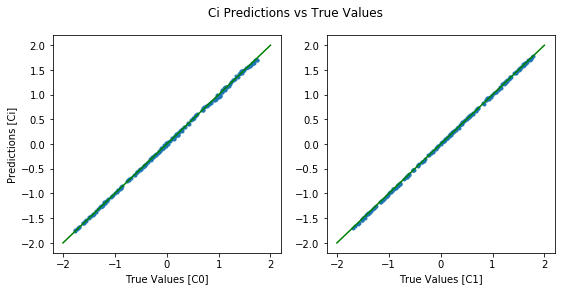

In [135]:
plot_predict(test_predictions_20_1_50, normed_test_Ci_df_50, lims=[-2,2])

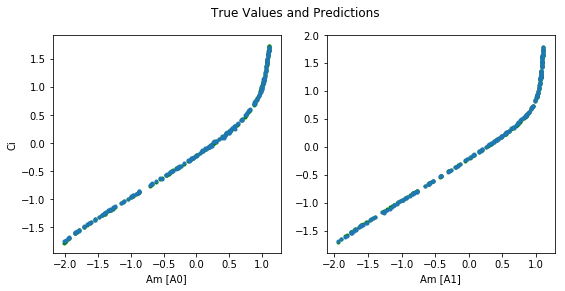

In [136]:
plot_true_and_pred(normed_test_Ci_df_50, test_predictions_20_1_50, normed_test_Am_df_50)

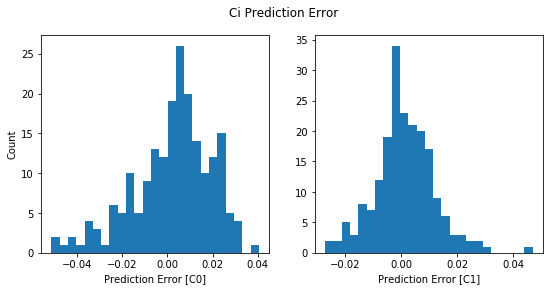

In [137]:
plot_error_hist(error_20_1_50)

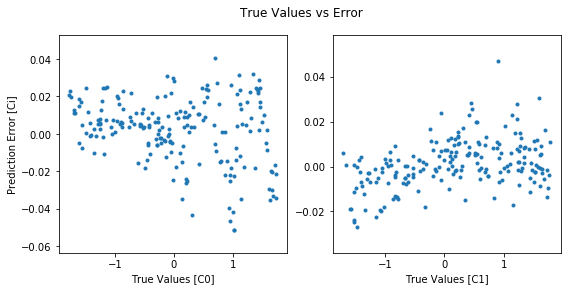

In [138]:
plot_true_v_error(normed_test_Ci_df_50, error_20_1_50)

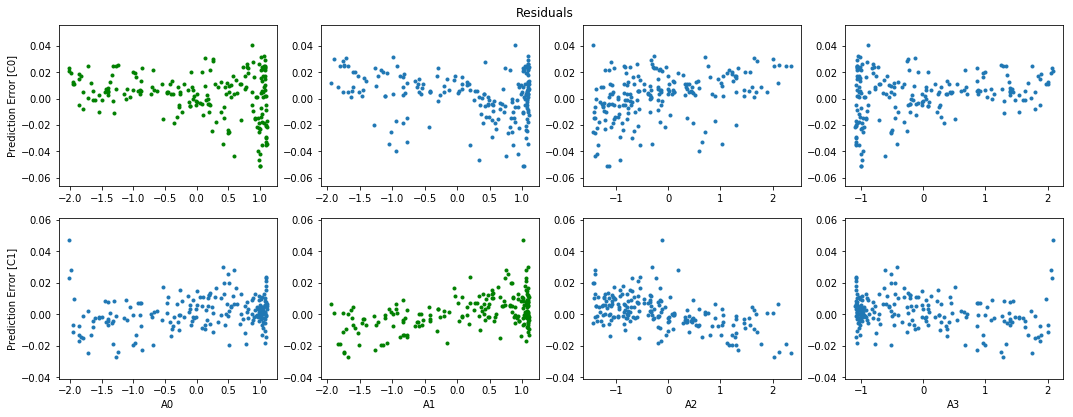

In [139]:
plot_residuals(normed_test_Am_df_50, error_20_1_50, green_list=[(0,0),(1,1),(2,2),(3,3)])

In [140]:
loss_20_1_50L, mae_20_1_50L, mse_20_1_50L = \
model_20_1_50.evaluate(large_normed_test_Am_df_50, large_normed_test_Ci_df_50, \
                        verbose=2)

1200/1200 - 0s - loss: 2.6229e-04 - mae: 0.0119 - mse: 2.6229e-04


In [141]:
# Scaled MAE
test_predictions_20_1_50L = model_20_1_50.predict(large_normed_test_Am_df_50)
error_20_1_50L = test_predictions_20_1_50L - large_normed_test_Ci_df_50
scaled_mae_20_1_50L = error_20_1_50L.abs().mean()*train_Ci_stats_50['std']
print(scaled_mae_20_1_50L)

C0    6.248882e-09
C1    3.892346e-09
dtype: float64


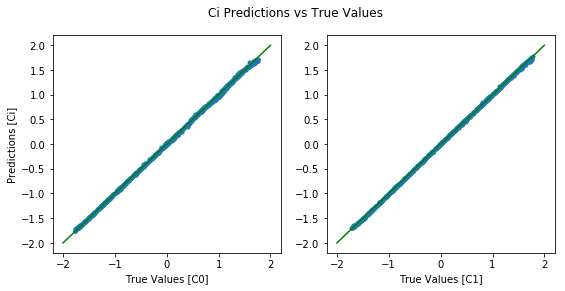

In [142]:
plot_predict(test_predictions_20_1_50L, large_normed_test_Ci_df_50, lims=[-2,2])

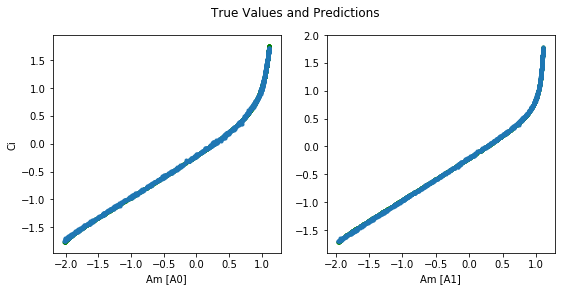

In [143]:
plot_true_and_pred(large_normed_test_Ci_df_50, test_predictions_20_1_50L, \
                   large_normed_test_Am_df_50)

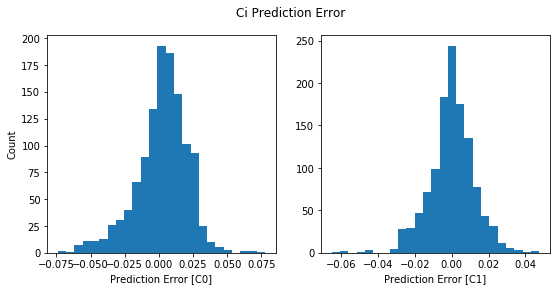

In [144]:
plot_error_hist(error_20_1_50L)

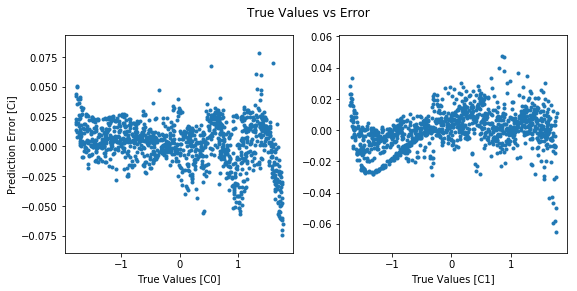

In [145]:
plot_true_v_error(large_normed_test_Ci_df_50, error_20_1_50L)

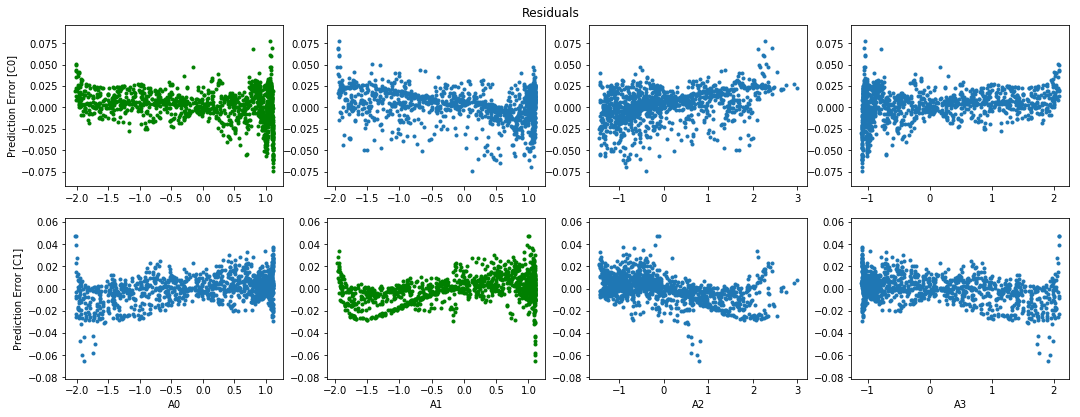

In [146]:
plot_residuals(large_normed_test_Am_df_50, error_20_1_50L, \
               green_list=[(0,0),(1,1),(2,2),(3,3)])

Now let's try a 10 node, 1 layer model

In [147]:
model_10_1_50 = build_model(10,1,"relu")


Epoch: 0, loss:1.3813,  mae:0.9558,  mse:1.3813,  val_loss:1.0161,  val_mae:0.8101,  val_mse:1.0161,  
....................................................................................................
Epoch: 100, loss:0.0068,  mae:0.0513,  mse:0.0068,  val_loss:0.0058,  val_mae:0.0507,  val_mse:0.0058,  
....................................................................................................
Epoch: 200, loss:0.0044,  mae:0.0401,  mse:0.0044,  val_loss:0.0037,  val_mae:0.0397,  val_mse:0.0037,  
....................................................................................................
Epoch: 300, loss:0.0029,  mae:0.0326,  mse:0.0029,  val_loss:0.0018,  val_mae:0.0288,  val_mse:0.0018,  
....................................................................................................
Epoch: 400, loss:0.0021,  mae:0.0288,  mse:0.0021,  val_loss:0.0015,  val_mae:0.0258,  val_mse:0.0015,  
........................................................................

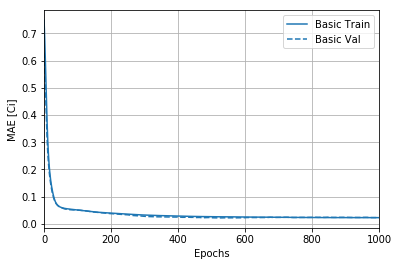

In [148]:
history = model_10_1_50.fit(normed_train_Am_df_50, normed_train_Ci_df_50,
  epochs=EPOCHS, validation_split = 0.1, verbose=0,
  callbacks=[tfdocs.modeling.EpochDots()])
plotter.plot({'Basic': history}, metric = "mae")
plt.ylabel('MAE [Ci]')
plt.show()

In [149]:
loss_10_1_50, mae_10_1_50, mse_10_1_50 = \
model_10_1_50.evaluate(normed_test_Am_df_50, normed_test_Ci_df_50, verbose=2)

200/200 - 0s - loss: 0.0012 - mae: 0.0248 - mse: 0.0012


In [150]:
# Scaled MAE
test_predictions_10_1_50 = model_10_1_50.predict(normed_test_Am_df_50)
error_10_1_50 = test_predictions_10_1_50 - normed_test_Ci_df_50
scaled_mae_10_1_50 = error_10_1_50.abs().mean()*train_Ci_stats_50['std']
print(scaled_mae_10_1_50)

C0    1.300974e-08
C1    8.116685e-09
dtype: float64


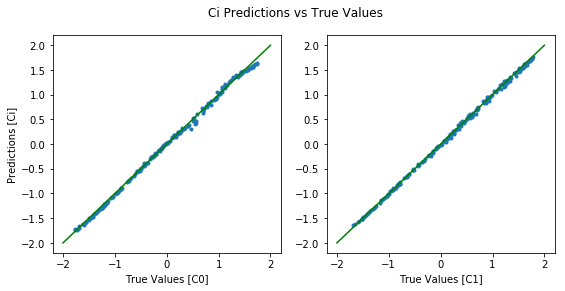

In [151]:
plot_predict(test_predictions_10_1_50, normed_test_Ci_df_50, lims=[-2,2])

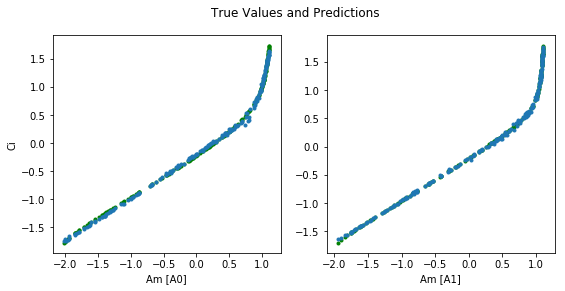

In [152]:
plot_true_and_pred(normed_test_Ci_df_50, test_predictions_10_1_50, normed_test_Am_df_50)

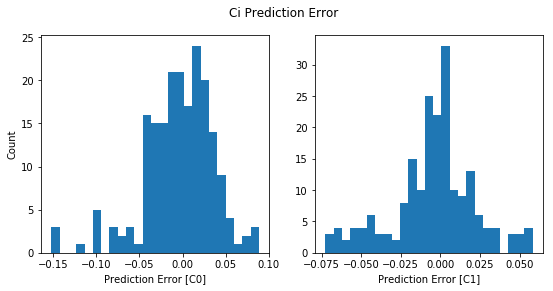

In [153]:
plot_error_hist(error_10_1_50)

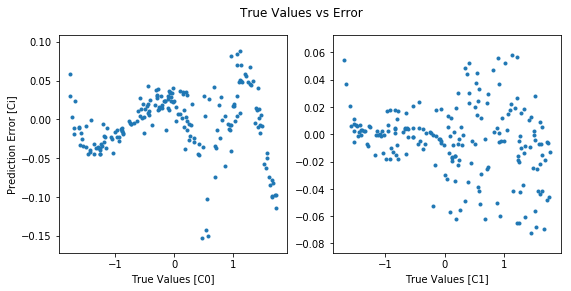

In [154]:
plot_true_v_error(normed_test_Ci_df_50, error_10_1_50)

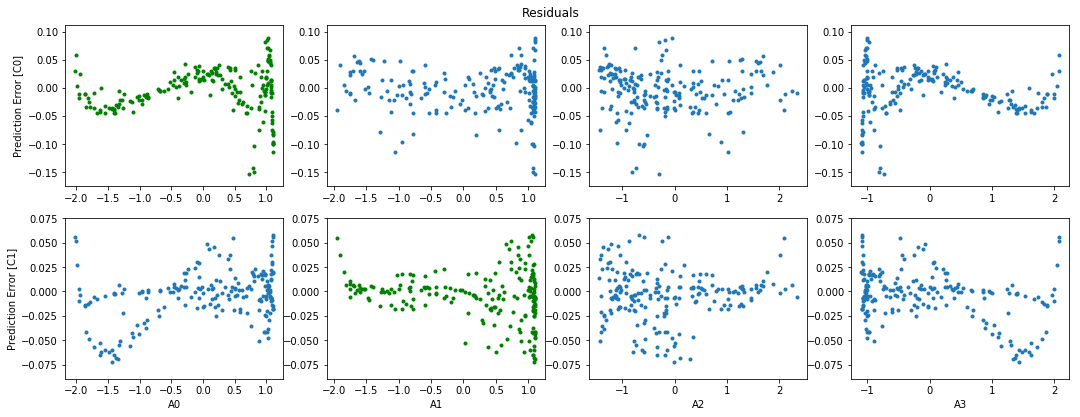

In [155]:
plot_residuals(normed_test_Am_df_50, error_10_1_50, green_list=[(0,0),(1,1),(2,2),(3,3)])

In [156]:
loss_10_1_50L, mae_10_1_50L, mse_10_1_50L = \
model_10_1_50.evaluate(large_normed_test_Am_df_50, large_normed_test_Ci_df_50, \
                        verbose=2)

1200/1200 - 0s - loss: 0.0013 - mae: 0.0259 - mse: 0.0013


In [157]:
# Scaled MAE
test_predictions_10_1_50L = model_10_1_50.predict(large_normed_test_Am_df_50)
error_10_1_50L = test_predictions_10_1_50L - large_normed_test_Ci_df_50
scaled_mae_10_1_50L = error_10_1_50L.abs().mean()*train_Ci_stats_50['std']
print(scaled_mae_10_1_50L)

C0    1.414548e-08
C1    7.912143e-09
dtype: float64


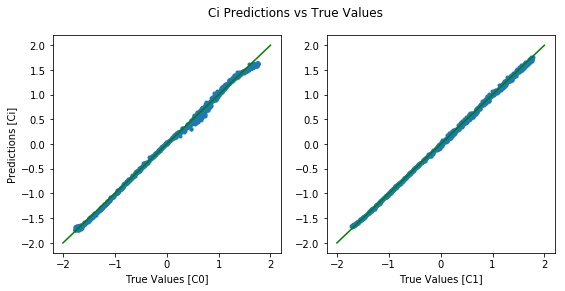

In [158]:
plot_predict(test_predictions_10_1_50L, large_normed_test_Ci_df_50, lims=[-2,2])

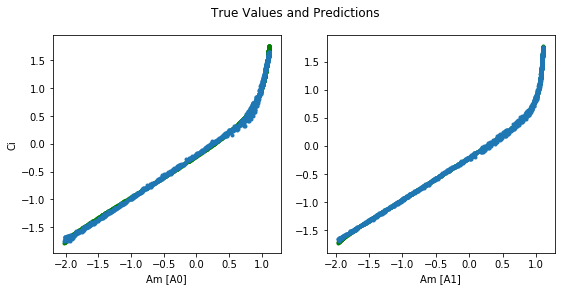

In [159]:
plot_true_and_pred(large_normed_test_Ci_df_50, test_predictions_10_1_50L, \
                   large_normed_test_Am_df_50)

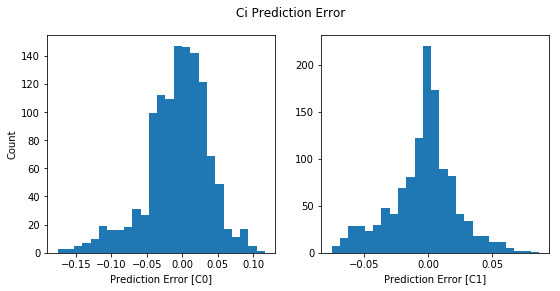

In [160]:
plot_error_hist(error_10_1_50L)

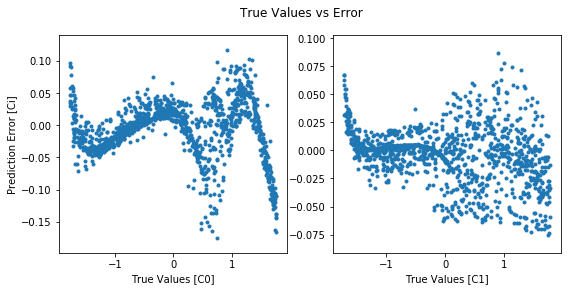

In [161]:
plot_true_v_error(large_normed_test_Ci_df_50, error_10_1_50L)

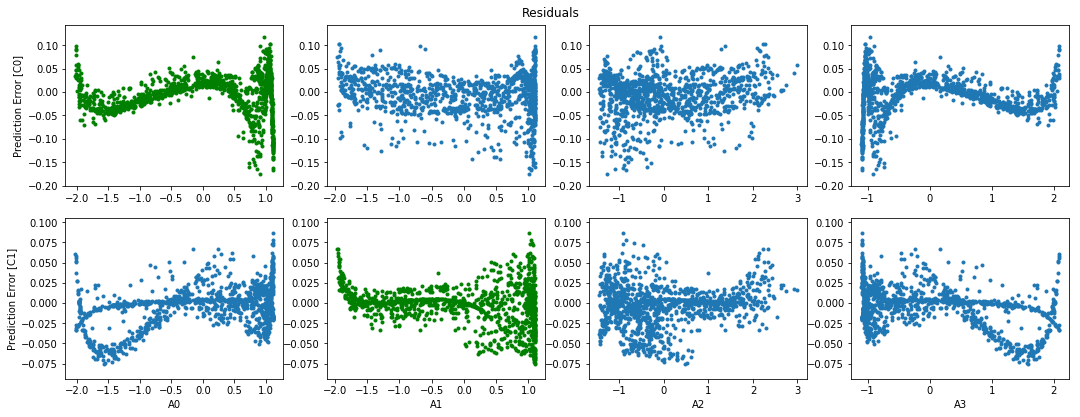

In [162]:
plot_residuals(large_normed_test_Am_df_50, error_10_1_50L, \
               green_list=[(0,0),(1,1),(2,2),(3,3)])

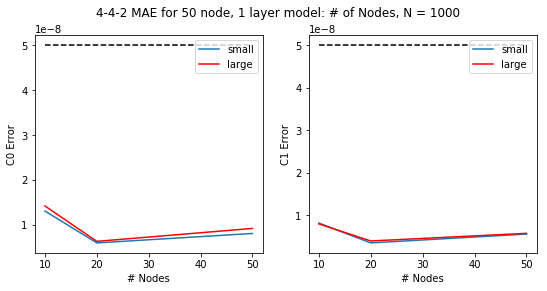

In [163]:
fig, ax = plt.subplots(1,2,figsize=(9,4))
fig.suptitle('4-4-2 MAE for 50 node, 1 layer model: # of Nodes, N = 1000')
for i in range(2):
    ax[i].plot([50,20,10],\
             [scaled_mae_50_1_50[i], scaled_mae_20_1_50[i], scaled_mae_10_1_50[i]], \
              label='small')
    ax[i].plot([50,20,10],\
             [scaled_mae_50_1_50L[i], scaled_mae_20_1_50L[i], scaled_mae_10_1_50L[i]],\
             'r', label='large')
#     ax[i].scatter([2000],[scaled_mae_50_1_mm[i]], marker='.', c='g', label='Min-Max')
#     ax[i].plot([10,50],[1e-7,1e-7],'k--')
    ax[i].plot([10,50],[5e-8,5e-8],'k--')
    ax[i].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    ax[i].legend(loc='upper right')
    ax[i].set_xlabel('# Nodes')
    ax[i].set_ylabel('C{} Error'.format(i))
#     ax[i].set_ylim(0,1.5e-7)

There's not much of a difference. Let's try using less data.

In [164]:
model_20_1_25 = build_model(20,1,"relu")


Epoch: 0, loss:1.1173,  mae:0.8996,  mse:1.1173,  val_loss:0.8790,  val_mae:0.8208,  val_mse:0.8790,  
....................................................................................................
Epoch: 100, loss:0.0078,  mae:0.0577,  mse:0.0078,  val_loss:0.0087,  val_mae:0.0639,  val_mse:0.0087,  
....................................................................................................
Epoch: 200, loss:0.0044,  mae:0.0431,  mse:0.0044,  val_loss:0.0045,  val_mae:0.0448,  val_mse:0.0045,  
....................................................................................................
Epoch: 300, loss:0.0024,  mae:0.0318,  mse:0.0024,  val_loss:0.0029,  val_mae:0.0377,  val_mse:0.0029,  
....................................................................................................
Epoch: 400, loss:0.0015,  mae:0.0265,  mse:0.0015,  val_loss:0.0012,  val_mae:0.0234,  val_mse:0.0012,  
........................................................................

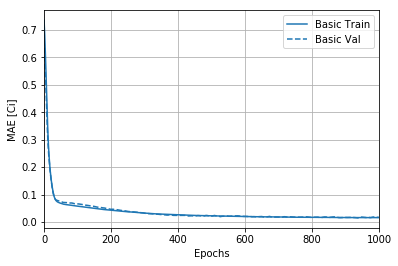

In [165]:
history = model_20_1_25.fit(normed_train_Am_df_25, normed_train_Ci_df_25,
  epochs=EPOCHS, validation_split = 0.1, verbose=0,
  callbacks=[tfdocs.modeling.EpochDots()])
plotter.plot({'Basic': history}, metric = "mae")
plt.ylabel('MAE [Ci]')
plt.show()

In [166]:
loss_20_1_25, mae_20_1_25, mse_20_1_25 = \
model_20_1_25.evaluate(normed_test_Am_df_25, normed_test_Ci_df_25, verbose=2)

100/100 - 0s - loss: 5.4268e-04 - mae: 0.0176 - mse: 5.4268e-04


In [167]:
# Scaled MAE
test_predictions_20_1_25 = model_20_1_25.predict(normed_test_Am_df_25)
error_20_1_25 = test_predictions_20_1_25 - normed_test_Ci_df_25
scaled_mae_20_1_25 = error_20_1_25.abs().mean()*train_Ci_stats_25['std']
print(scaled_mae_20_1_25)

C0    7.987994e-09
C1    7.144287e-09
dtype: float64


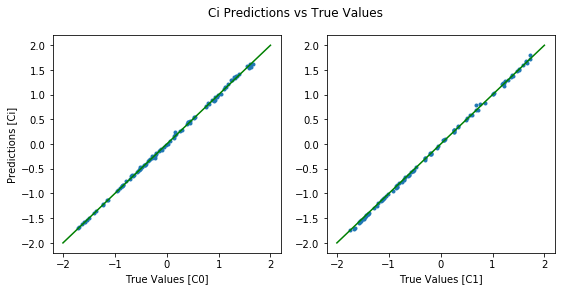

In [168]:
plot_predict(test_predictions_20_1_25, normed_test_Ci_df_25, lims=[-2,2])

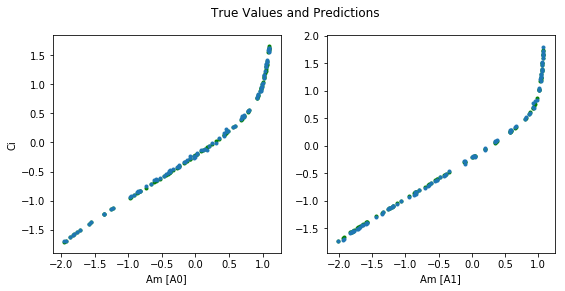

In [169]:
plot_true_and_pred(normed_test_Ci_df_25, test_predictions_20_1_25, normed_test_Am_df_25)

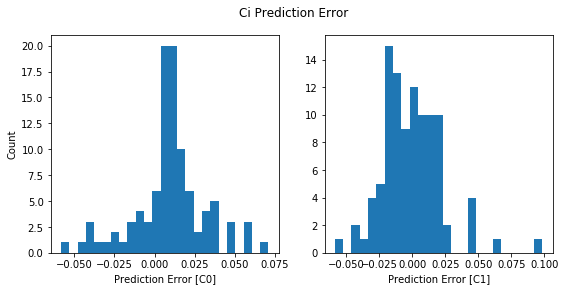

In [170]:
plot_error_hist(error_20_1_25)

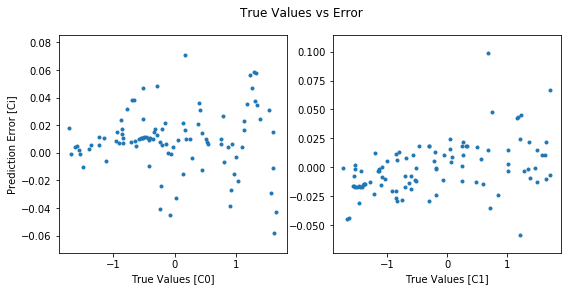

In [171]:
plot_true_v_error(normed_test_Ci_df_25, error_20_1_25)

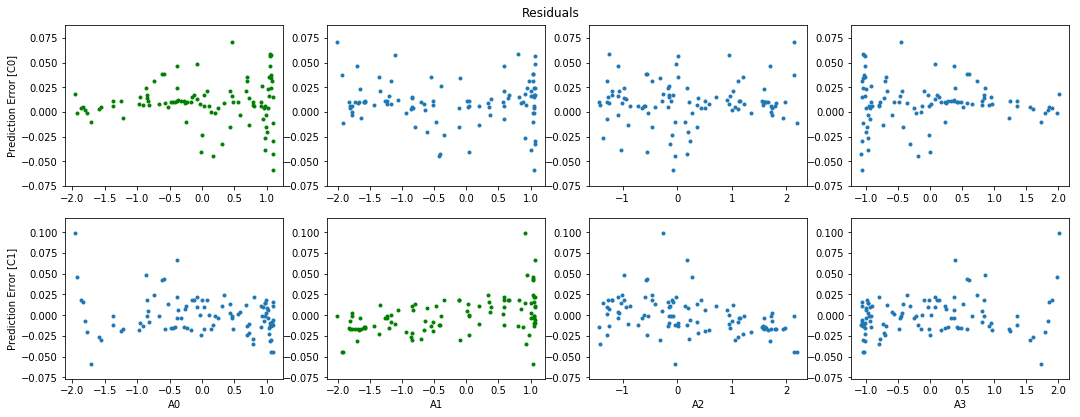

In [172]:
plot_residuals(normed_test_Am_df_25, error_20_1_25, green_list=[(0,0),(1,1),(2,2),(3,3)])

In [173]:
loss_20_1_25L, mae_20_1_25L, mse_20_1_25L = \
model_20_1_25.evaluate(large_normed_test_Am_df_25, large_normed_test_Ci_df_25, \
                        verbose=2)

1600/1600 - 0s - loss: 5.2992e-04 - mae: 0.0172 - mse: 5.2992e-04


In [174]:
# Scaled MAE
test_predictions_20_1_25L = model_20_1_25.predict(large_normed_test_Am_df_25)
error_20_1_25L = test_predictions_20_1_25L - large_normed_test_Ci_df_25
scaled_mae_20_1_25L = error_20_1_25L.abs().mean()*train_Ci_stats_25['std']
print(scaled_mae_20_1_25L)

C0    7.981841e-09
C1    6.819988e-09
dtype: float64


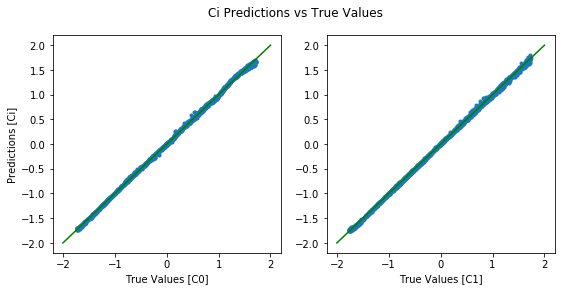

In [175]:
plot_predict(test_predictions_20_1_25L, large_normed_test_Ci_df_25, lims=[-2,2])

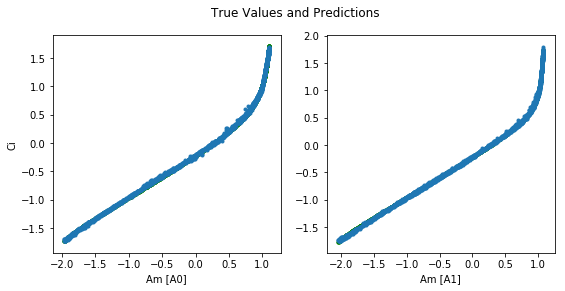

In [176]:
plot_true_and_pred(large_normed_test_Ci_df_25, test_predictions_20_1_25L, \
                   large_normed_test_Am_df_25)

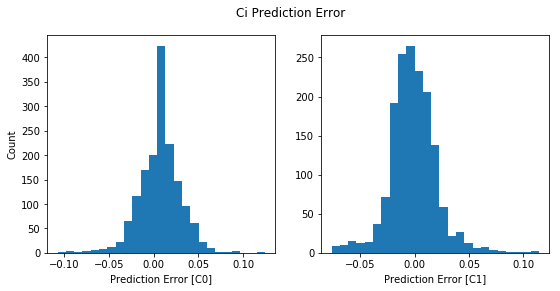

In [177]:
plot_error_hist(error_20_1_25L)

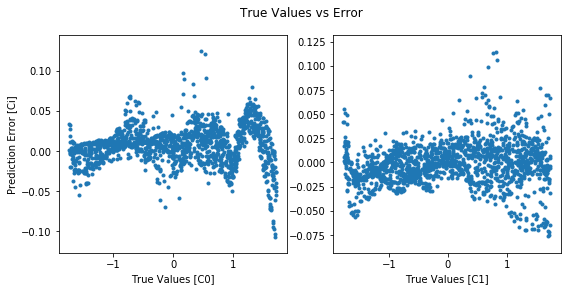

In [178]:
plot_true_v_error(large_normed_test_Ci_df_25, error_20_1_25L)

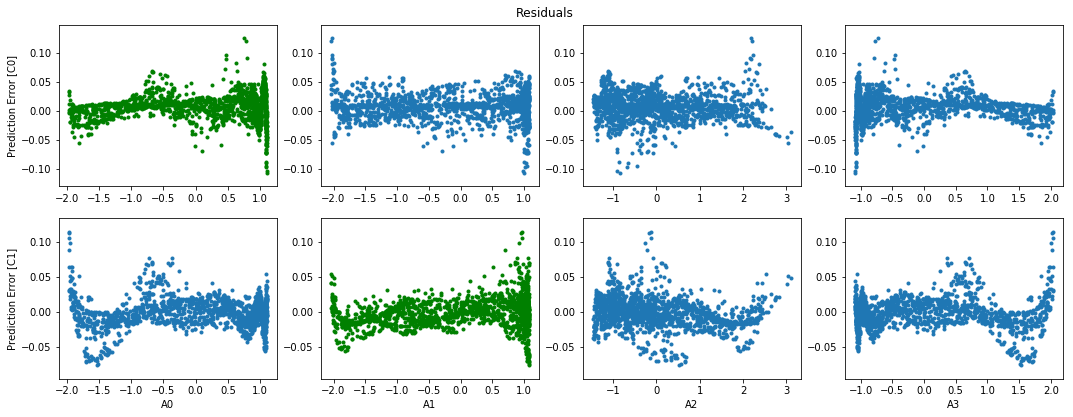

In [179]:
plot_residuals(large_normed_test_Am_df_25, error_20_1_25L, \
               green_list=[(0,0),(1,1),(2,2),(3,3)])

In [180]:
model_10_1_25 = build_model(10,1,"relu")


Epoch: 0, loss:1.5877,  mae:1.0106,  mse:1.5877,  val_loss:1.4837,  val_mae:0.9876,  val_mse:1.4837,  
....................................................................................................
Epoch: 100, loss:0.0081,  mae:0.0580,  mse:0.0081,  val_loss:0.0093,  val_mae:0.0647,  val_mse:0.0093,  
....................................................................................................
Epoch: 200, loss:0.0051,  mae:0.0443,  mse:0.0051,  val_loss:0.0048,  val_mae:0.0445,  val_mse:0.0048,  
....................................................................................................
Epoch: 300, loss:0.0034,  mae:0.0370,  mse:0.0034,  val_loss:0.0033,  val_mae:0.0391,  val_mse:0.0033,  
....................................................................................................
Epoch: 400, loss:0.0021,  mae:0.0304,  mse:0.0021,  val_loss:0.0016,  val_mae:0.0280,  val_mse:0.0016,  
........................................................................

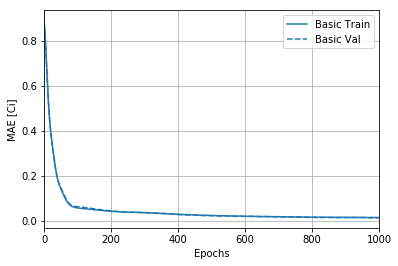

In [181]:
history = model_10_1_25.fit(normed_train_Am_df_25, normed_train_Ci_df_25,
  epochs=EPOCHS, validation_split = 0.1, verbose=0,
  callbacks=[tfdocs.modeling.EpochDots()])
plotter.plot({'Basic': history}, metric = "mae")
plt.ylabel('MAE [Ci]')
plt.show()

In [182]:
loss_10_1_25, mae_10_1_25, mse_10_1_25 = \
model_10_1_25.evaluate(normed_test_Am_df_25, normed_test_Ci_df_25, verbose=2)

100/100 - 0s - loss: 4.6579e-04 - mae: 0.0151 - mse: 4.6579e-04


In [183]:
# Scaled MAE
test_predictions_10_1_25 = model_10_1_25.predict(normed_test_Am_df_25)
error_10_1_25 = test_predictions_10_1_25 - normed_test_Ci_df_25
scaled_mae_10_1_25 = error_10_1_25.abs().mean()*train_Ci_stats_25['std']
print(scaled_mae_10_1_25)

C0    8.033820e-09
C1    4.979151e-09
dtype: float64


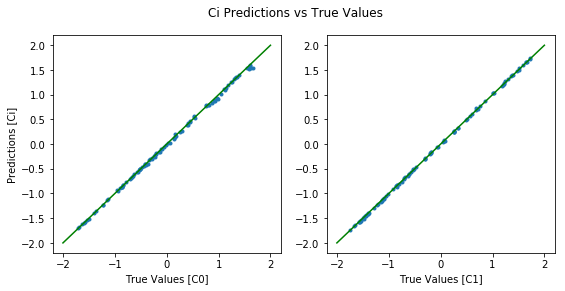

In [184]:
plot_predict(test_predictions_10_1_25, normed_test_Ci_df_25, lims=[-2,2])

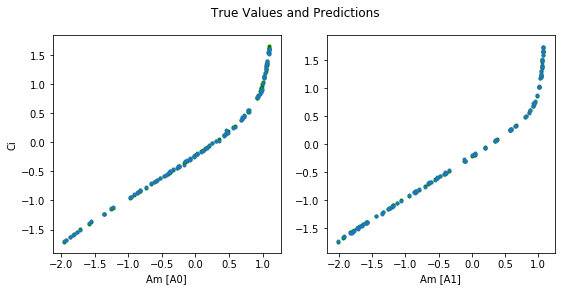

In [185]:
plot_true_and_pred(normed_test_Ci_df_25, test_predictions_10_1_25, normed_test_Am_df_25)

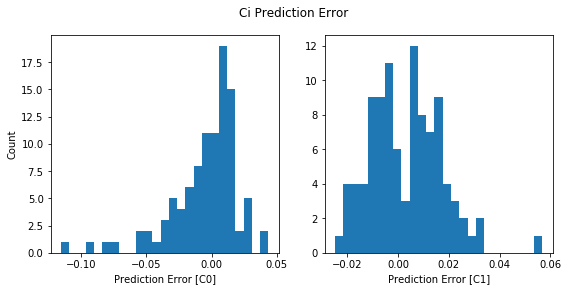

In [186]:
plot_error_hist(error_10_1_25)

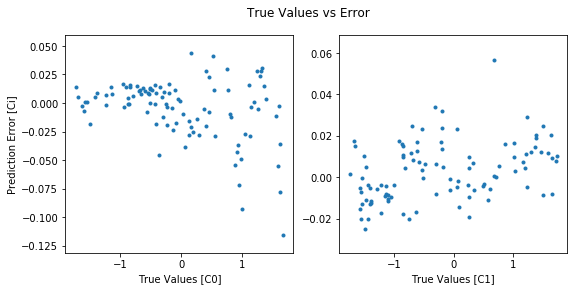

In [187]:
plot_true_v_error(normed_test_Ci_df_25, error_10_1_25)

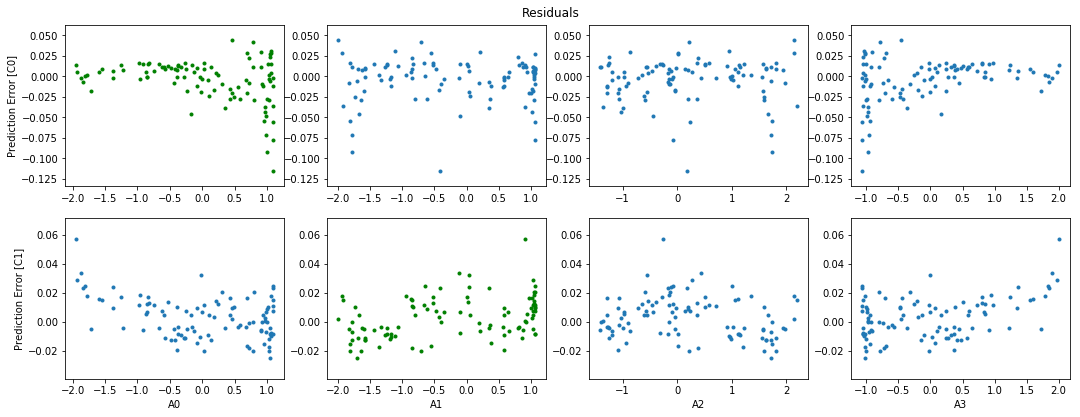

In [188]:
plot_residuals(normed_test_Am_df_25, error_10_1_25, green_list=[(0,0),(1,1),(2,2),(3,3)])

In [189]:
loss_10_1_25L, mae_10_1_25L, mse_10_1_25L = \
model_10_1_25.evaluate(large_normed_test_Am_df_25, large_normed_test_Ci_df_25, \
                        verbose=2)

1600/1600 - 0s - loss: 5.8497e-04 - mae: 0.0167 - mse: 5.8497e-04


In [190]:
# Scaled MAE
test_predictions_10_1_25L = model_10_1_25.predict(large_normed_test_Am_df_25)
error_10_1_25L = test_predictions_10_1_25L - large_normed_test_Ci_df_25
scaled_mae_10_1_25L = error_10_1_25L.abs().mean()*train_Ci_stats_25['std']
print(scaled_mae_10_1_25L)

C0    8.960666e-09
C1    5.426037e-09
dtype: float64


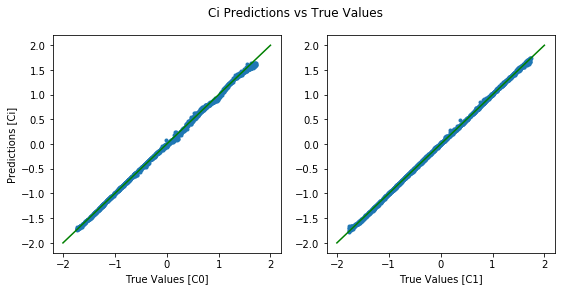

In [191]:
plot_predict(test_predictions_10_1_25L, large_normed_test_Ci_df_25, lims=[-2,2])

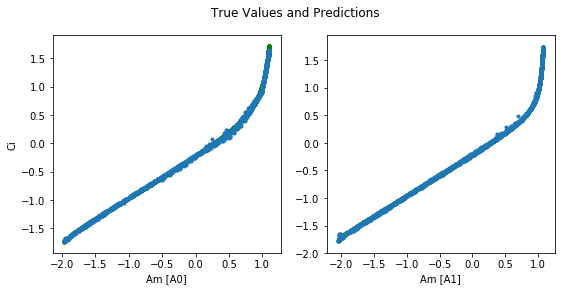

In [192]:
plot_true_and_pred(large_normed_test_Ci_df_25, test_predictions_10_1_25L, \
                   large_normed_test_Am_df_25)

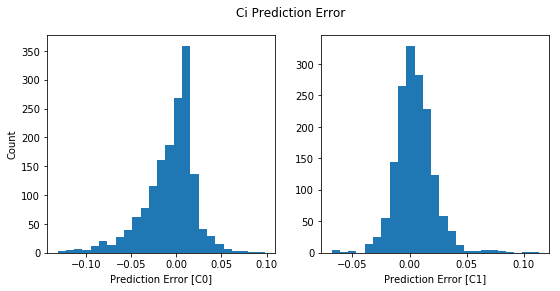

In [193]:
plot_error_hist(error_10_1_25L)

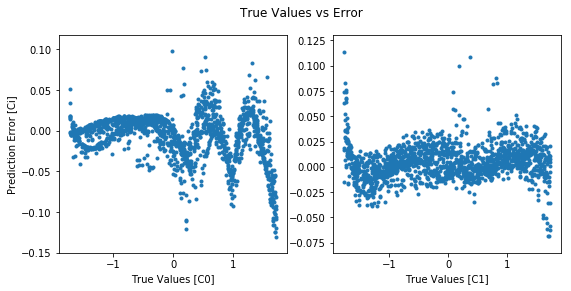

In [194]:
plot_true_v_error(large_normed_test_Ci_df_25, error_10_1_25L)

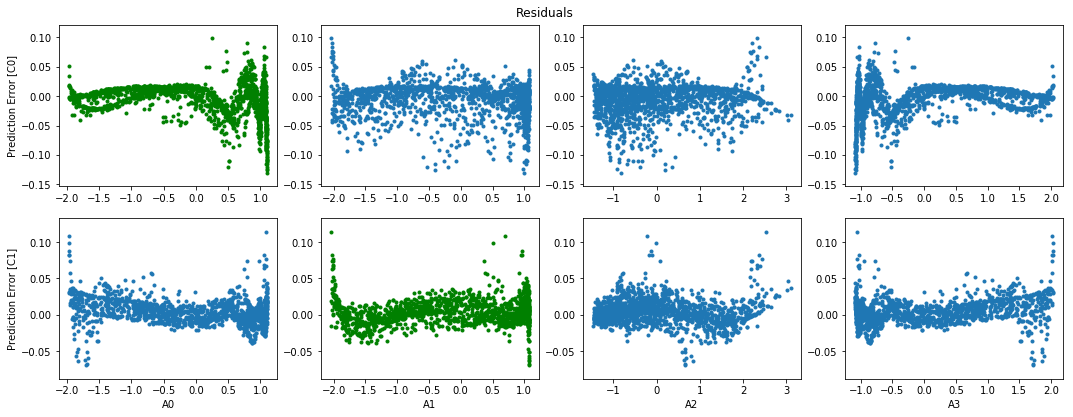

In [195]:
plot_residuals(large_normed_test_Am_df_25, error_10_1_25L, \
               green_list=[(0,0),(1,1),(2,2),(3,3)])

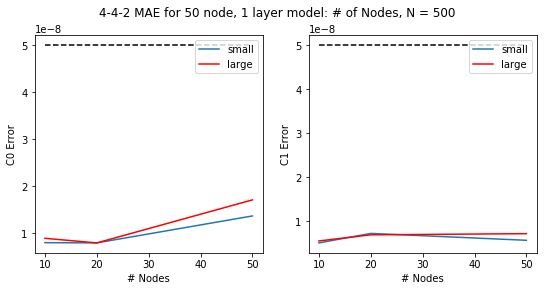

In [196]:
fig, ax = plt.subplots(1,2,figsize=(9,4))
fig.suptitle('4-4-2 MAE for 50 node, 1 layer model: # of Nodes, N = 500')
for i in range(2):
    ax[i].plot([50,20,10],\
             [scaled_mae_50_1_25[i], scaled_mae_20_1_25[i], scaled_mae_10_1_25[i]], \
              label='small')
    ax[i].plot([50,20,10],\
             [scaled_mae_50_1_25L[i], scaled_mae_20_1_25L[i], scaled_mae_10_1_25L[i]],\
             'r', label='large')
#     ax[i].plot([10,50],[1e-7,1e-7],'k--')
    ax[i].plot([10,50],[5e-8,5e-8],'k--')
    ax[i].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    ax[i].legend(loc='upper right')
    ax[i].set_xlabel('# Nodes')
    ax[i].set_ylabel('C{} Error'.format(i))
#     ax[i].set_ylim(0,1.5e-7)